In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco

flanksize=10

onehot_data = np.load('extracted_onehot.npy')[:,60-flanksize:60+21+flanksize]
hypothetical_data = np.load('extracted_hypothetical_scores.npy')[:,60-flanksize:60+21+flanksize]
contrib_data = np.load('extracted_contrib_scores.npy')[:,60-flanksize:60+21+flanksize]

contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=contrib_data,
                                 rev_tracks=contrib_data[:,::-1, ::-1])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hypothetical_data,
                                    rev_tracks=hypothetical_data[:,::-1, ::-1])
onehot_track = modisco.core.DataTrack(name="onehot",
                         fwd_tracks=onehot_data,
                         rev_tracks=onehot_data[:,::-1, ::-1])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track, onehot_track])

coords = [modisco.core.Coordinate(
            example_idx=idx, start=flanksize,
            end=flanksize+21, is_revcomp=False) for idx in range(len(onehot_data))]
all_seqlets = [x for x in track_set.create_seqlets(coords=coords, flanks=flanksize) if np.sum(x["contrib_scores"].corefwd) > 0]

/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


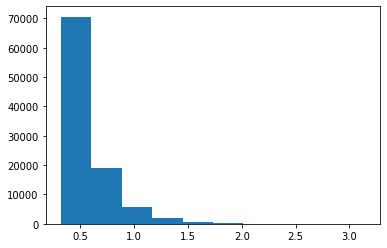

In [3]:
from matplotlib import pyplot as plt
plt.hist([np.sum(x["contrib_scores"].corefwd) for x in all_seqlets])
plt.show()

In [4]:
seqlets_subsample = [all_seqlets[i] for i in np.random.RandomState(1).choice(
                                              np.arange(len(all_seqlets)), size=5000,replace=False)]

In [5]:
len(seqlets_subsample)

5000

In [41]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

min_overlap_frac=0.6

affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    metric=modisco.util.l1norm_contin_jaccard_sim,
                    n_jobs=10, min_overlap_frac=min_overlap_frac)

affmat, offsets, isfwdmat = affmat_computer(seqlets_subsample, onehot_trackname="onehot",
                                            hyp_trackname="hypcontrib_scores")

np.save("affmat_"+str(min_overlap_frac)+".npy", affmat)
np.save("offsets_"+str(min_overlap_frac)+".npy", offsets)
np.save("isfwdmat_"+str(min_overlap_frac)+".npy", isfwdmat)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   30.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  2.0min


KeyboardInterrupt: 

In [12]:
affmat = np.load("affmat_0.6.npy")
offsets = np.load("offsets_0.6.npy")
isfwdmat = np.load("isfwdmat_0.6.npy")

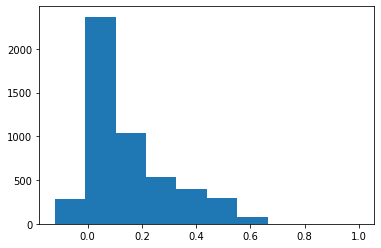

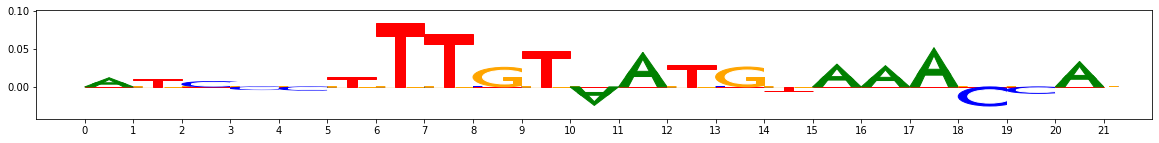

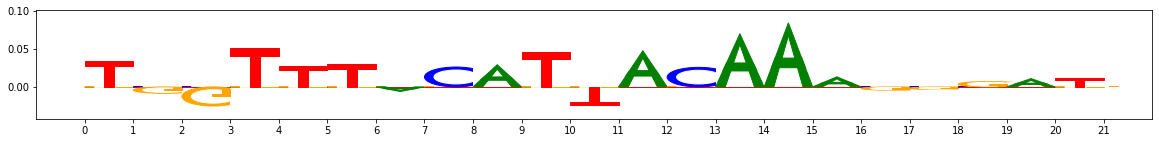

In [13]:
from modisco.visualization import viz_sequence

idx=4
plt.hist(affmat[idx])
viz_sequence.plot_weights(seqlets_subsample[idx]["contrib_scores"].corefwd)
viz_sequence.plot_weights(seqlets_subsample[idx]["contrib_scores"].corerev)
plt.show()

In [14]:
import modisco.core
reload(modisco.core)
import modisco.affinitymat
reload(modisco.affinitymat)

flatten = 1
distmat = np.log(1.0/(flatten*np.maximum(affmat,1e-7)) - (1.0/flatten - 1))

import umap
import leidenalg
n_neighbors = 10
tsne_adapted = modisco.affinitymat.tsne_density_adaptation(dist_mat=distmat,
                                                           perplexity=n_neighbors)

[t-SNE] Computing 4999 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.036s...
[t-SNE] Computed neighbors for 5000 samples in 3.000s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.218048


Median number of neighbors - tsne 36.0


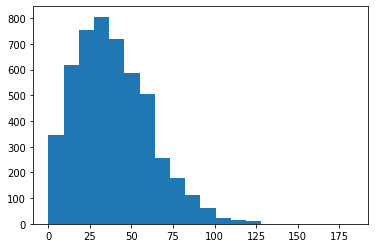

In [15]:
print("Median number of neighbors - tsne",np.median(np.sum(tsne_adapted>0, axis=1)))
plt.hist(np.sum(tsne_adapted>0, axis=1), bins=20)
plt.show()

In [16]:
from collections import Counter

#get Leiden averaged over different seeds
averaging_rounds = 0
current_affmat = np.linalg.matrix_power(tsne_adapted, 1)
for round_num in range(averaging_rounds):
    current_affmat = modisco.affinitymat.average_over_different_seeds(
                        affmat=current_affmat,
                        clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                partitiontype=leidenalg.ModularityVertexPartition,
                                                n_iterations=1),
                        nseeds=200)

the_clustering = modisco.affinitymat.take_best_over_different_seeds(affmat=current_affmat,
                                                clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                    partitiontype=leidenalg.ModularityVertexPartition,
                                                    n_iterations=-1),
                                                nseeds=10)
print(Counter(the_clustering))

Quality: 0.9595520524004323

Counter({0: 155, 1: 125, 3: 116, 2: 116, 4: 112, 5: 110, 6: 107, 7: 104, 8: 103, 9: 96, 10: 90, 11: 90, 12: 90, 13: 89, 15: 85, 14: 85, 16: 84, 17: 80, 18: 77, 19: 76, 20: 72, 21: 69, 22: 66, 23: 62, 24: 62, 25: 59, 26: 58, 28: 58, 27: 58, 29: 58, 30: 57, 31: 55, 32: 51, 33: 50, 34: 50, 35: 49, 36: 46, 37: 45, 38: 44, 39: 44, 40: 43, 41: 43, 43: 42, 42: 42, 46: 40, 45: 40, 44: 40, 47: 38, 48: 36, 49: 36, 50: 34, 51: 33, 52: 32, 53: 31, 54: 30, 55: 29, 56: 28, 58: 28, 57: 28, 60: 27, 59: 27, 61: 26, 63: 25, 62: 25, 64: 24, 65: 24, 67: 23, 69: 23, 68: 23, 66: 23, 70: 22, 71: 20, 73: 19, 72: 19, 75: 19, 74: 19, 76: 18, 77: 17, 79: 17, 78: 17, 81: 16, 82: 16, 80: 16, 83: 15, 84: 15, 85: 14, 86: 13, 89: 13, 87: 13, 88: 13, 92: 12, 94: 12, 91: 12, 95: 12, 93: 12, 90: 12, 96: 11, 97: 10, 100: 9, 105: 9, 103: 9, 99: 9, 106: 9, 98: 9, 104: 9, 101: 9, 102: 9, 107: 8, 108: 8, 110: 8, 109: 8, 118: 7, 119: 7, 121: 7, 113: 7, 116: 7, 120: 7, 115: 7, 114: 7, 117: 7, 112: 

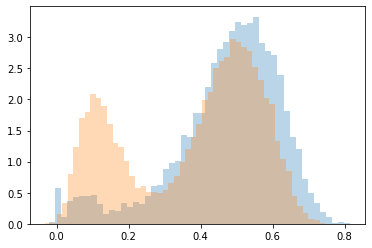

In [42]:
#compare clusters
cluster1 = 3
cluster2 = 0
incluster1mask = cluster1==the_clustering
incluster2mask = cluster2==the_clustering
zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
cluster1_within = plt.hist(zerodiagaffmat[incluster1mask][:,incluster1mask].ravel(),
                           bins=50, density=True, alpha=0.3)
#cluster2_within = plt.hist(zerodiagaffmat[incluster2mask][:,incluster2mask].ravel(),
#                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(zerodiagaffmat[incluster1mask][:,incluster2mask].ravel(),
                             bins=50, density=True, alpha=0.3)
plt.show()

In [37]:
#find an example with very high within-cluster similarity but high dissim to the other cluster
np.argmax(np.median(zerodiagaffmat[:,incluster1mask],axis=-1) - np.median(zerodiagaffmat[:,incluster2mask],axis=-1))

4780

In [38]:
#find an example with very high within-cluster similarity but high dissim to the other cluster
np.argmax(np.median(zerodiagaffmat[:,incluster2mask],axis=-1) - np.median(zerodiagaffmat[:,incluster1mask],axis=-1))

3920

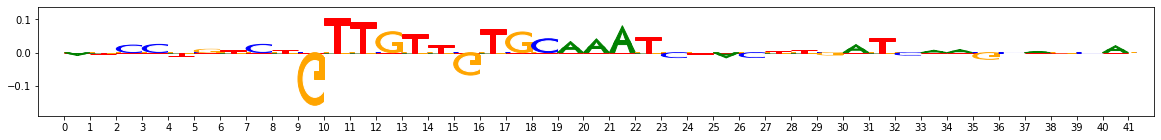

In [39]:
viz_sequence.plot_weights(seqlets_subsample[4780]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))

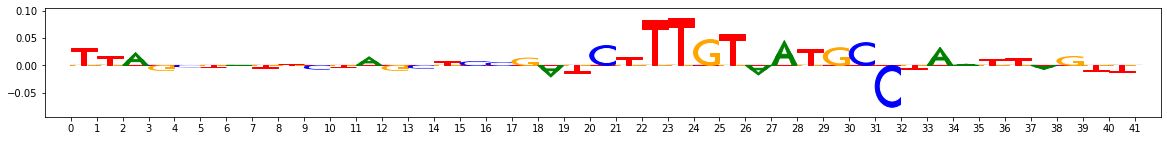

In [40]:
viz_sequence.plot_weights(seqlets_subsample[3920]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))

In [30]:
dir(seqlets_subsample[3039]["contrib_scores"])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fwd',
 '_rev',
 'corefwd',
 'corelength',
 'corerev',
 'get_core_with_flank',
 'get_revcomp',
 'hasrev',
 'left_flank',
 'right_flank']

Numbed of clusters: 226
Cluster idx 0 size 155


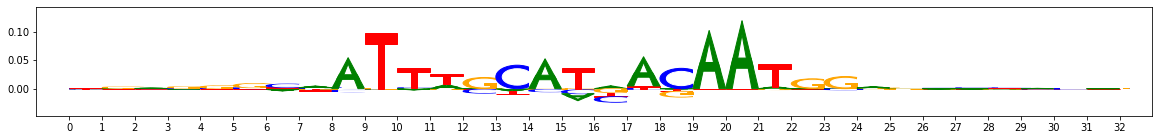

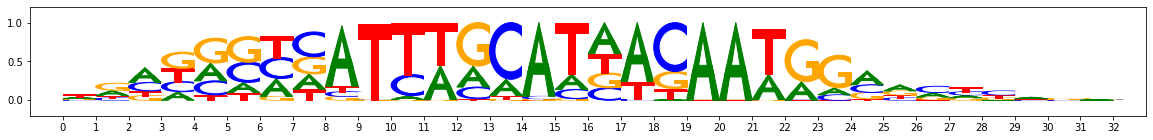

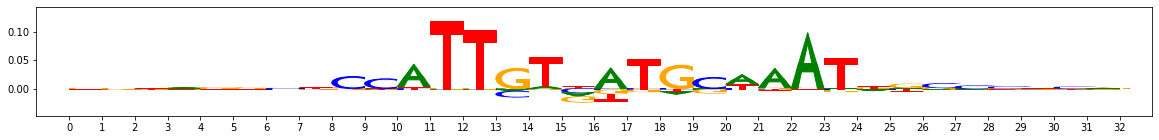

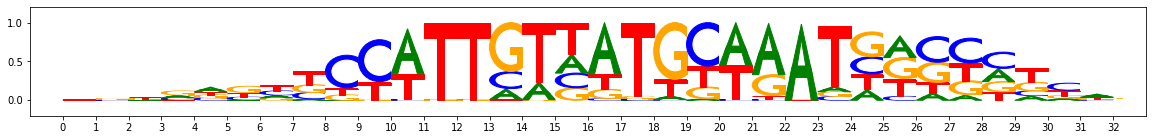

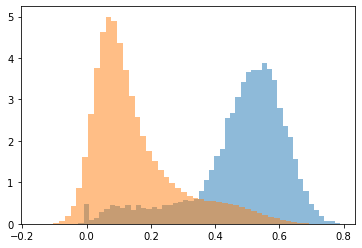

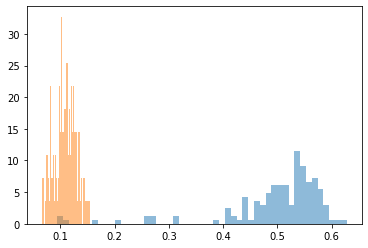

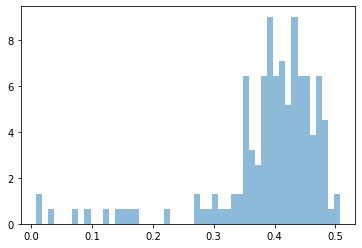

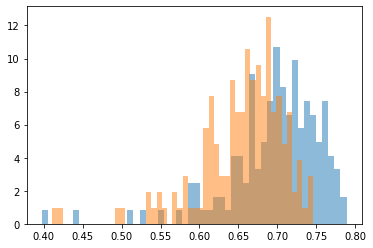

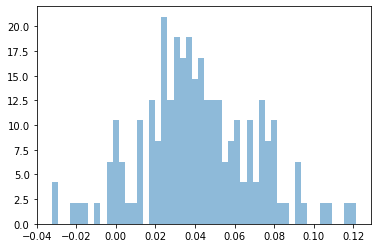

Cluster idx 1 size 125


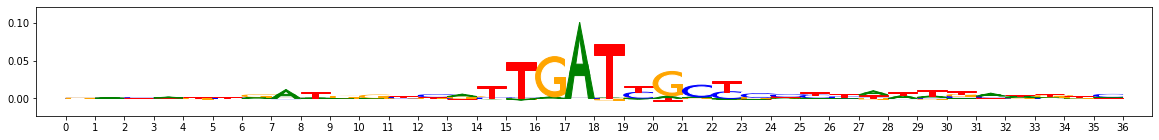

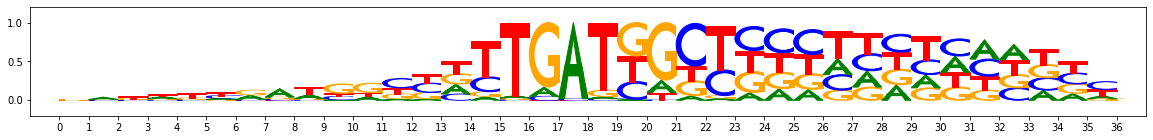

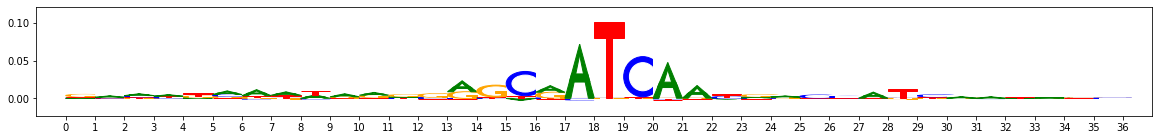

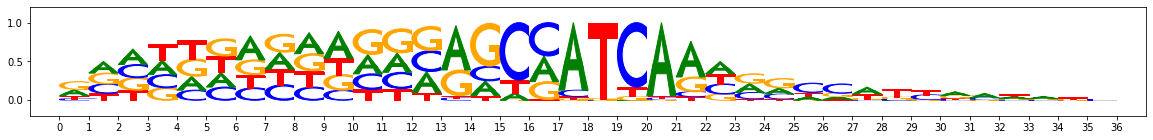

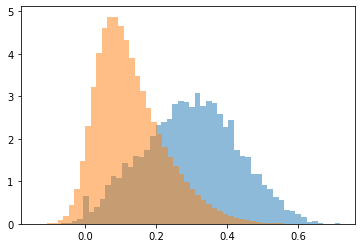

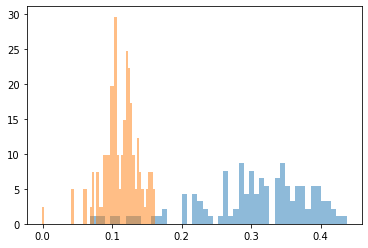

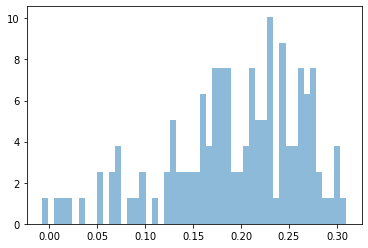

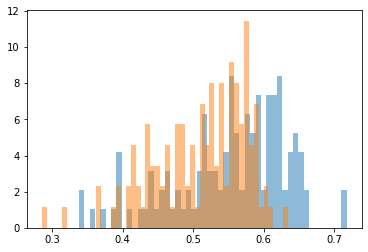

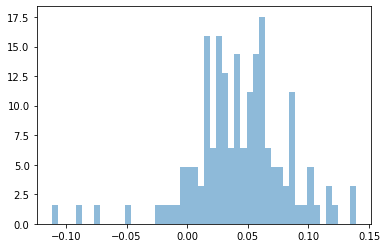

Cluster idx 2 size 116


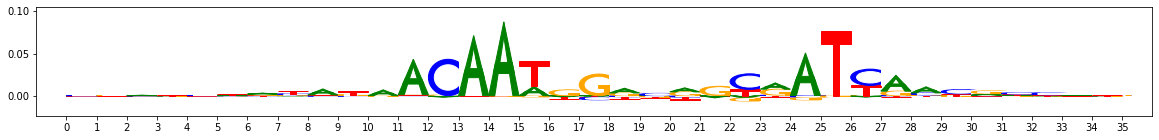

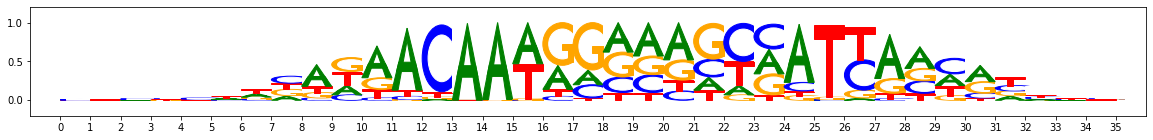

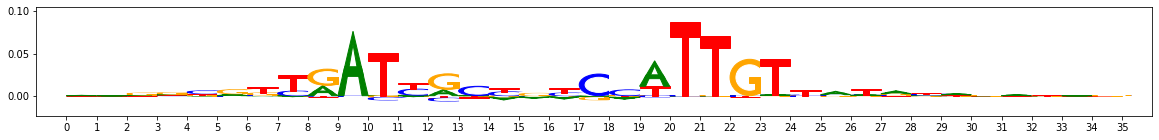

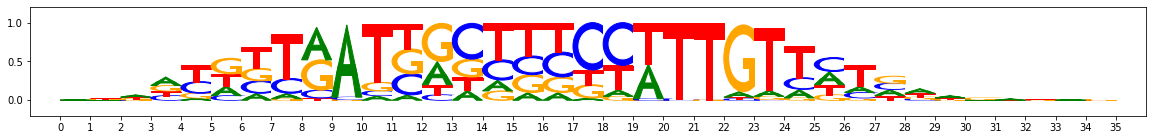

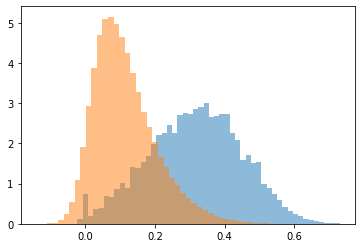

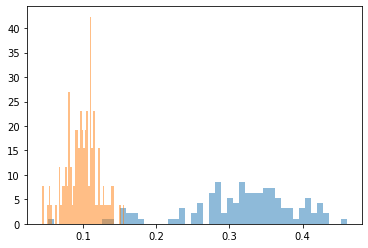

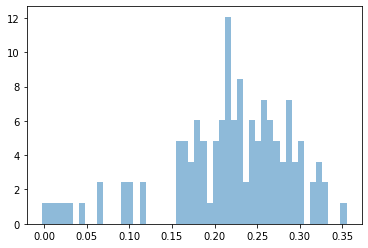

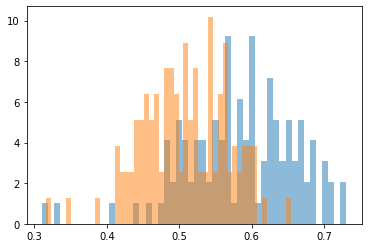

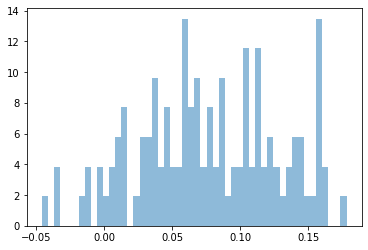

Cluster idx 3 size 116


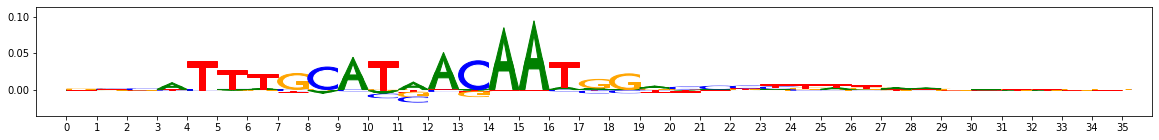

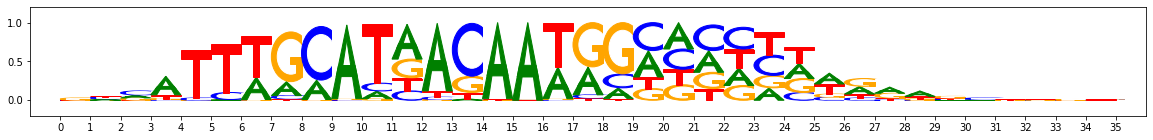

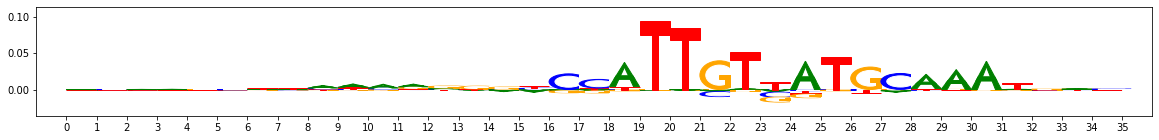

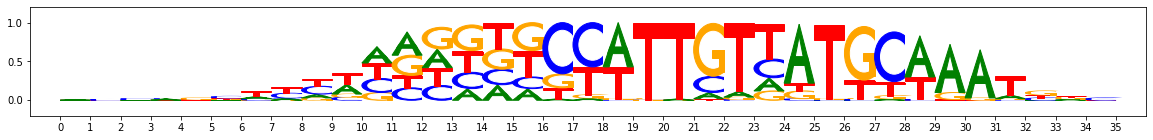

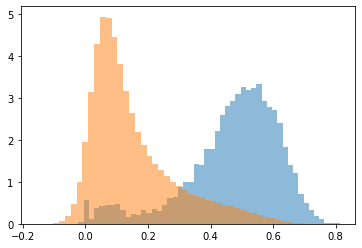

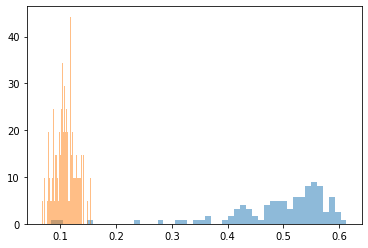

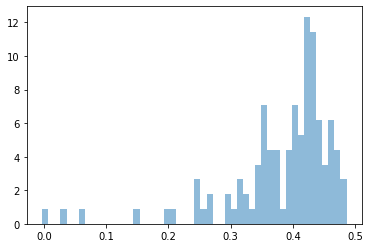

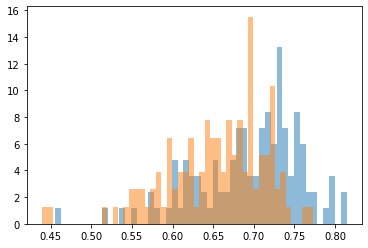

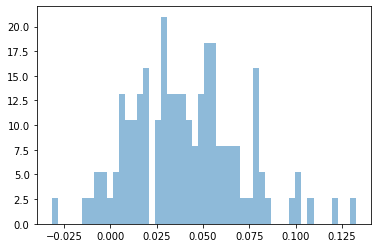

Cluster idx 4 size 112


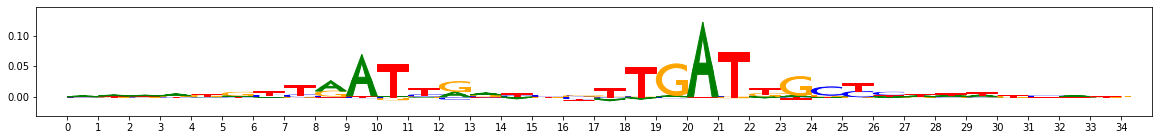

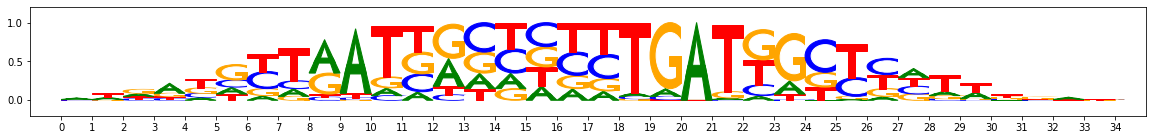

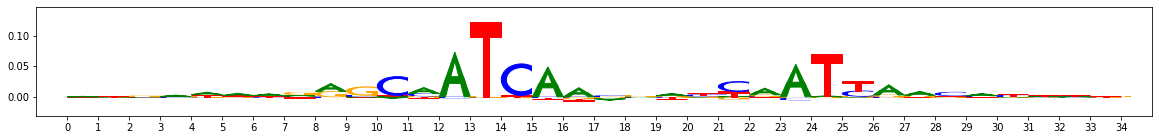

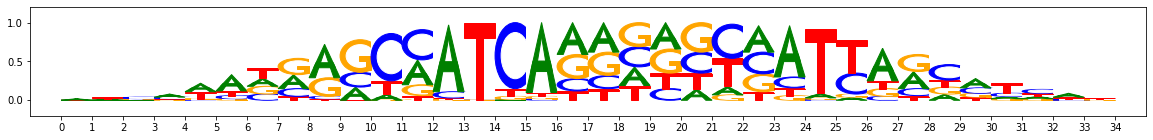

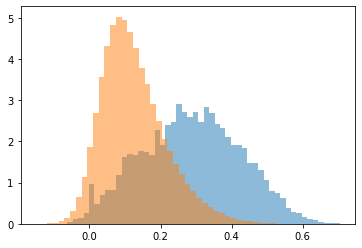

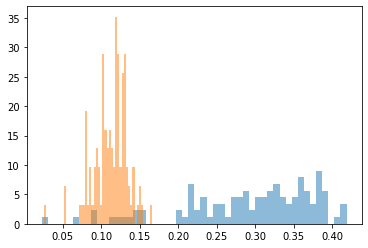

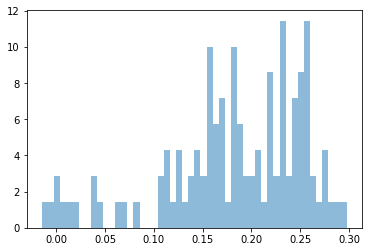

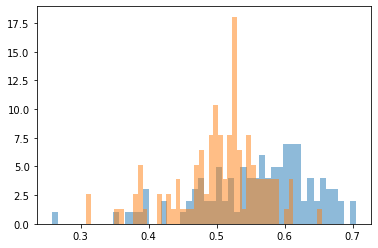

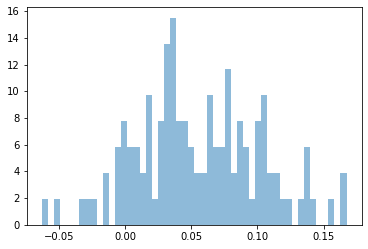

Cluster idx 5 size 110


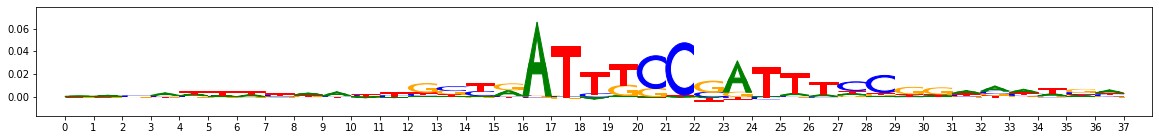

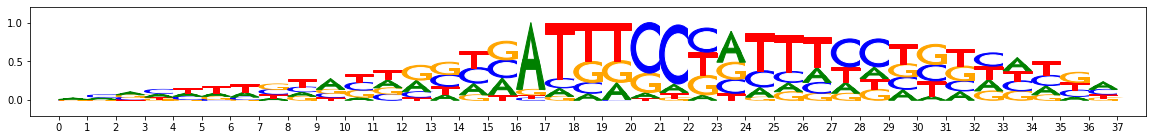

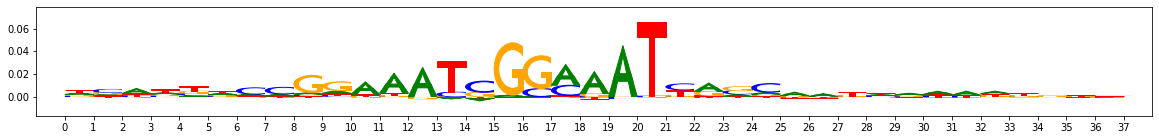

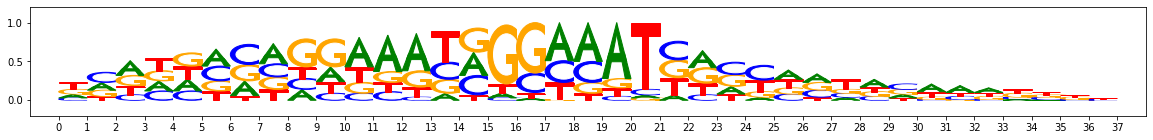

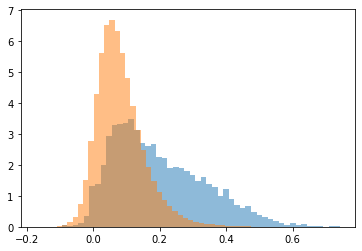

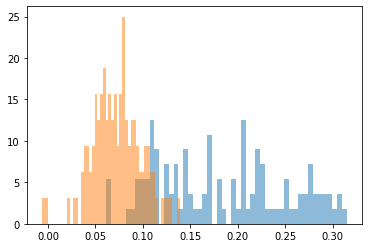

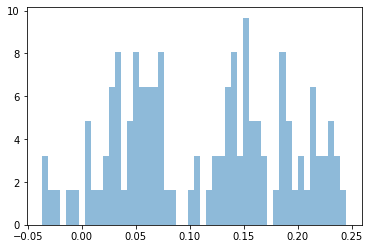

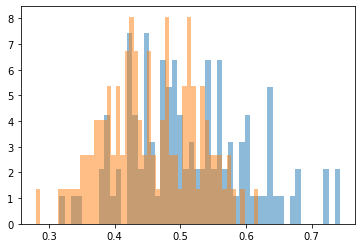

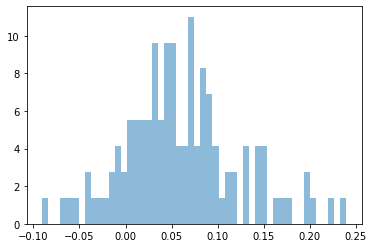

Cluster idx 6 size 107


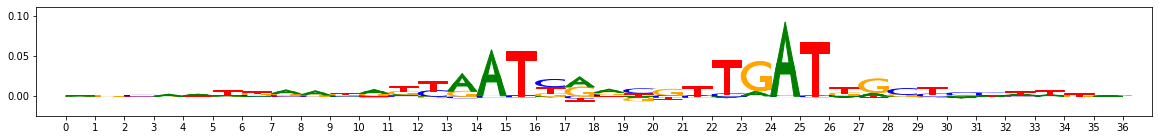

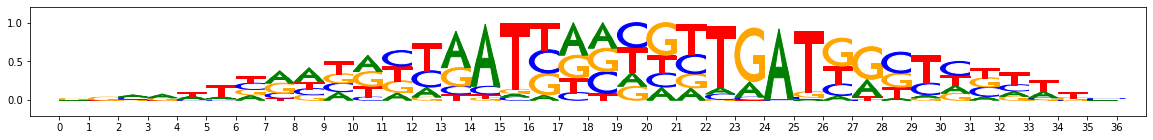

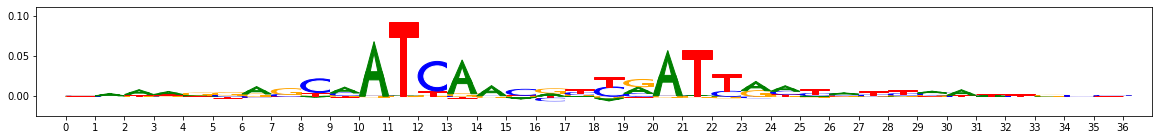

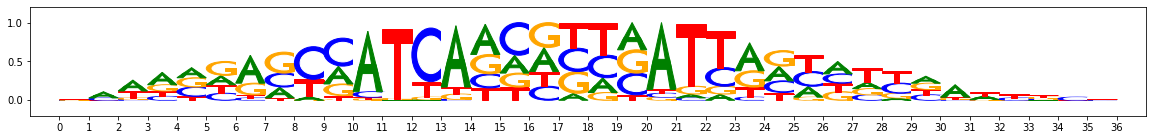

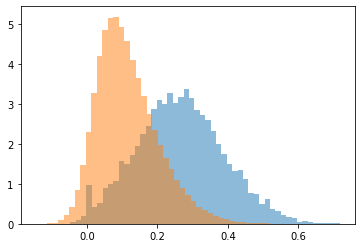

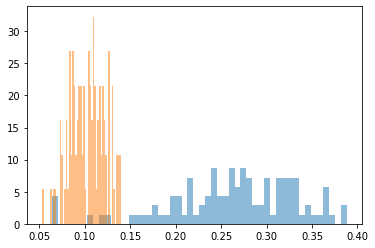

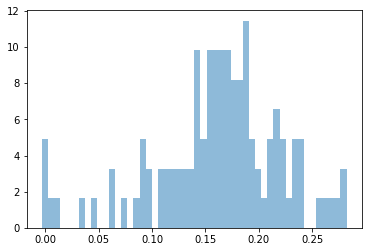

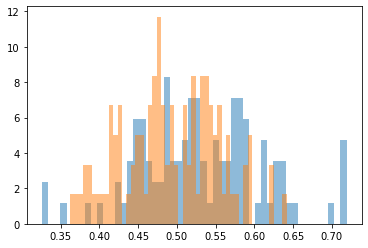

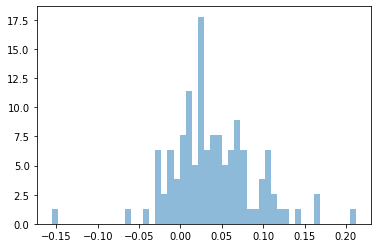

Cluster idx 7 size 104


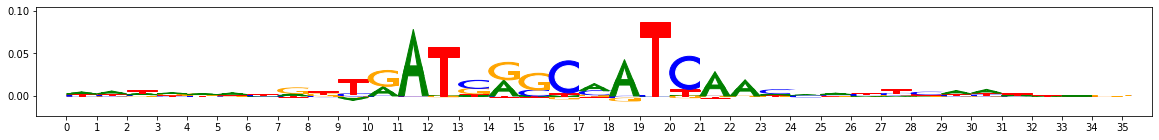

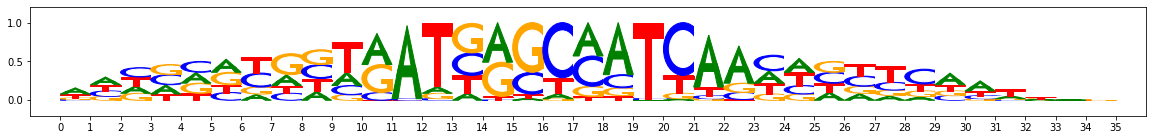

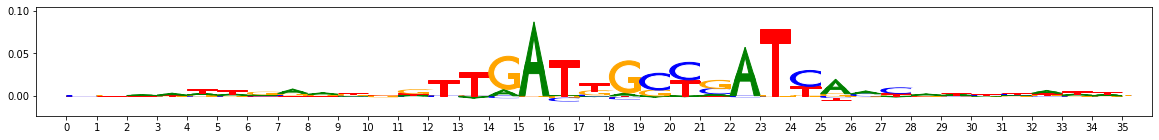

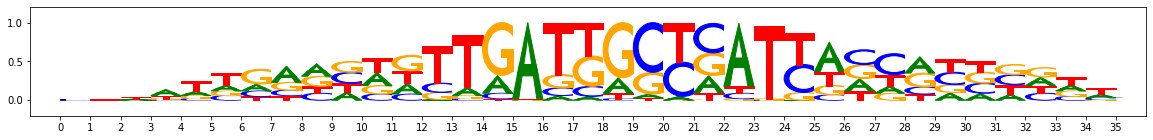

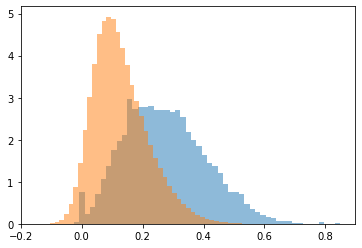

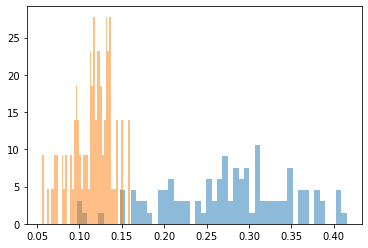

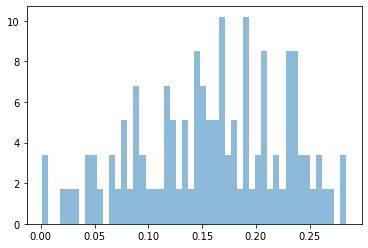

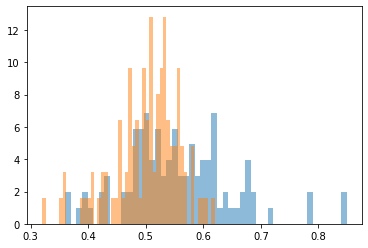

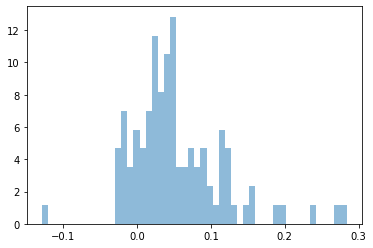

Cluster idx 8 size 103


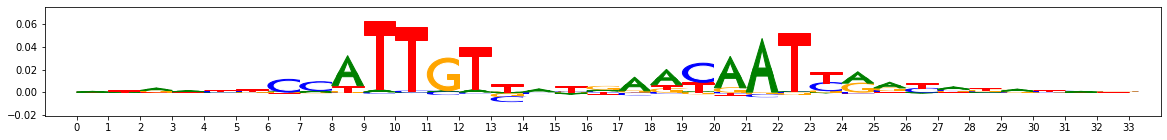

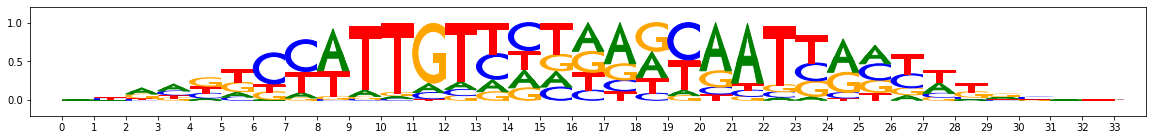

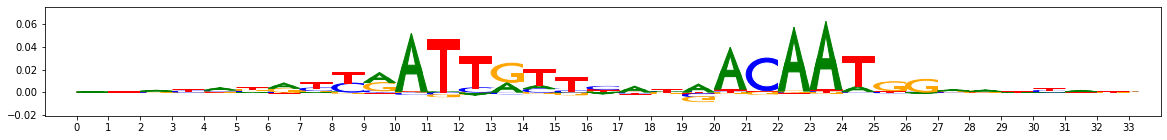

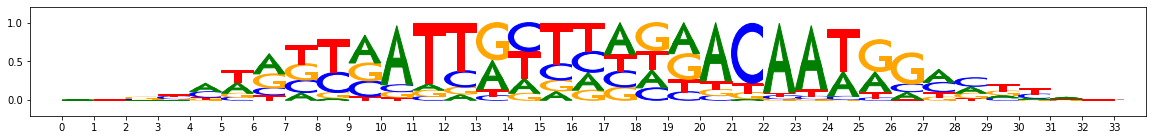

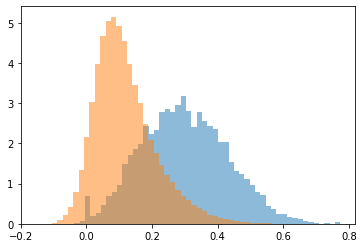

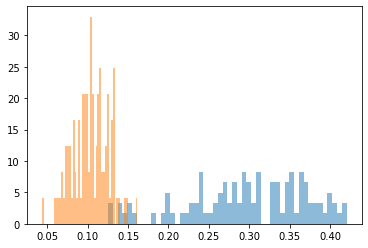

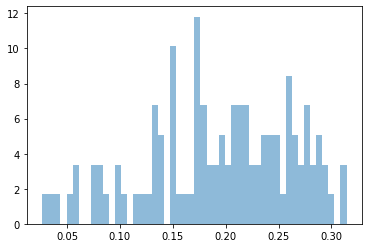

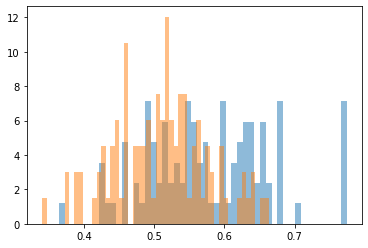

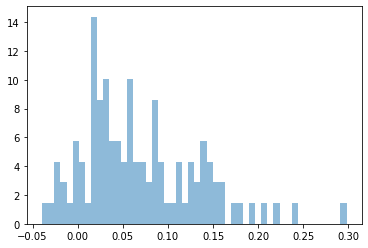

Cluster idx 9 size 96


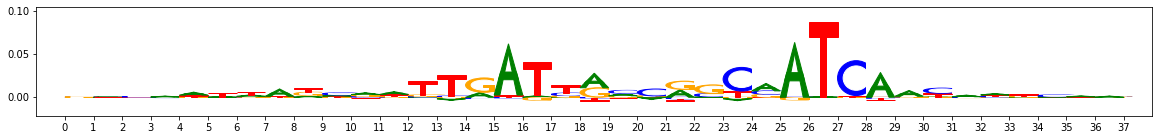

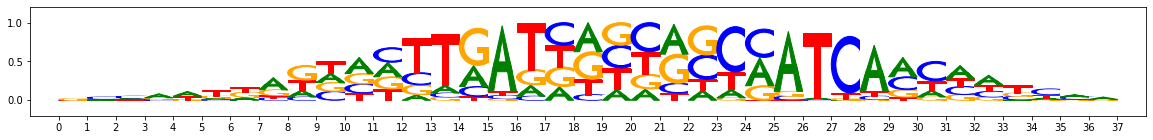

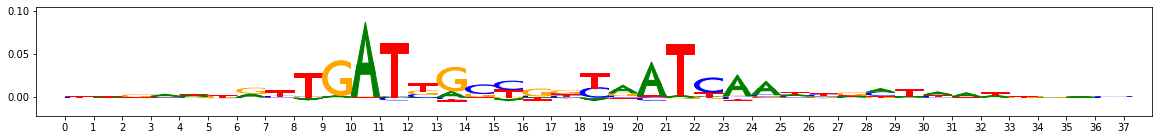

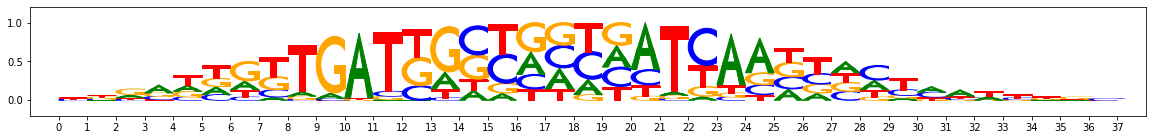

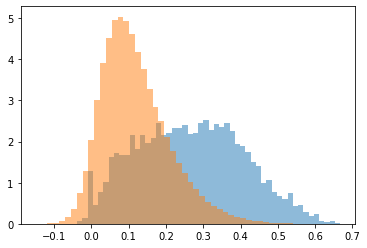

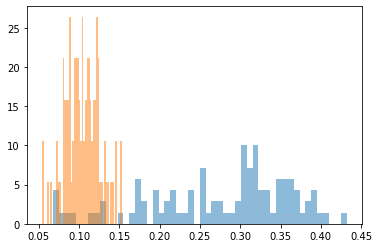

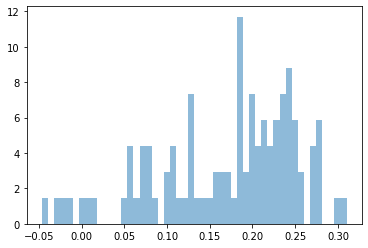

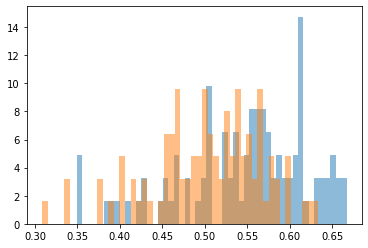

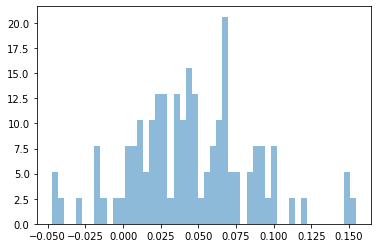

Cluster idx 10 size 90


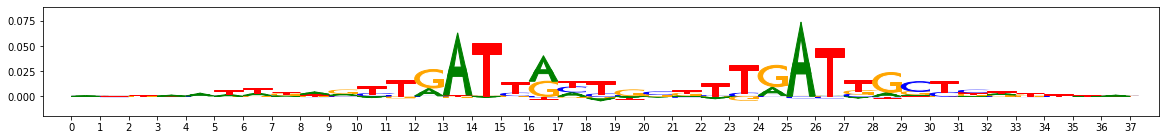

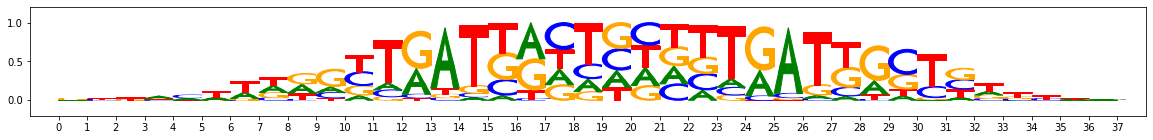

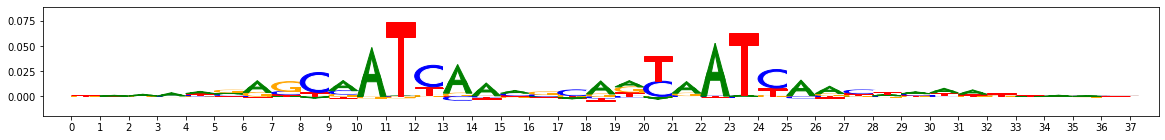

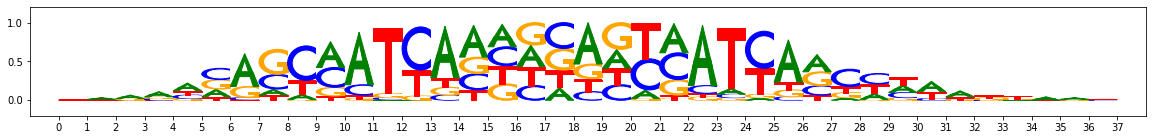

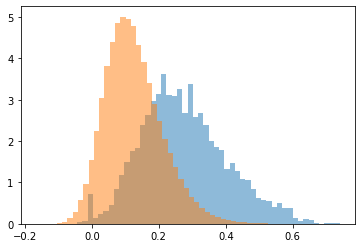

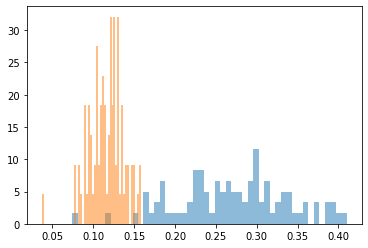

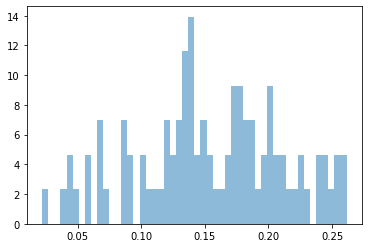

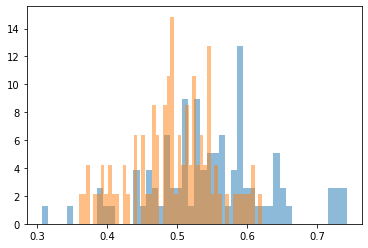

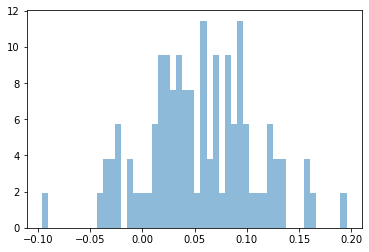

Cluster idx 11 size 90


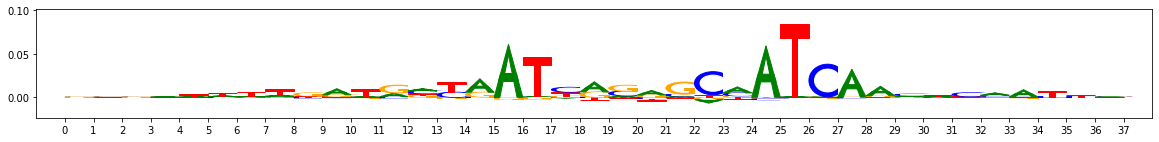

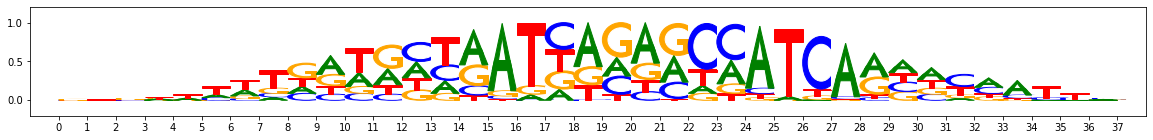

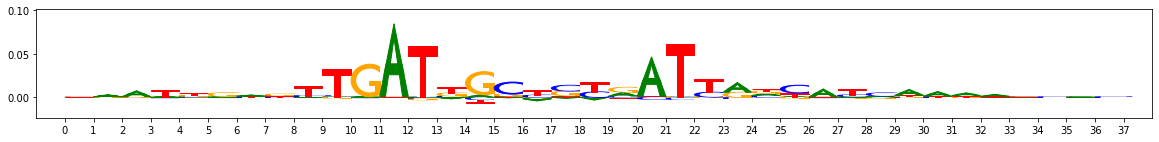

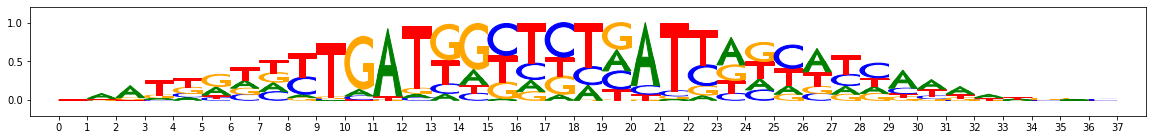

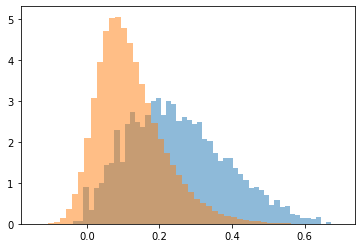

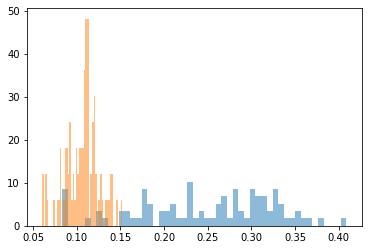

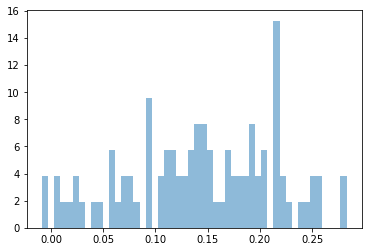

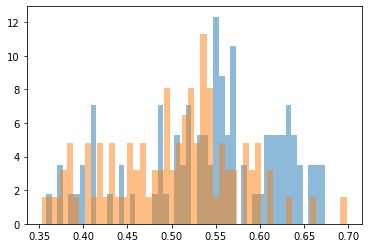

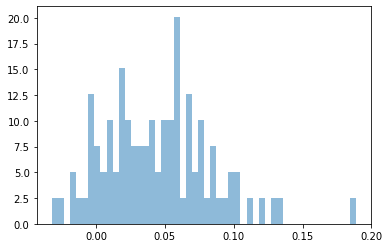

Cluster idx 12 size 90


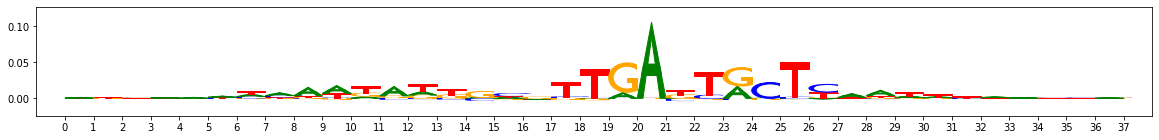

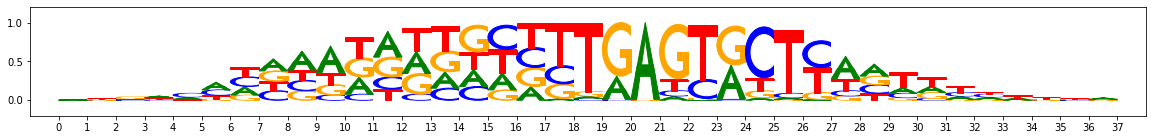

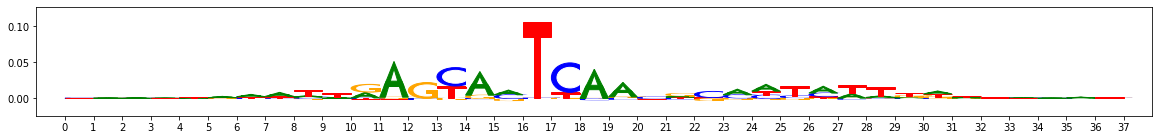

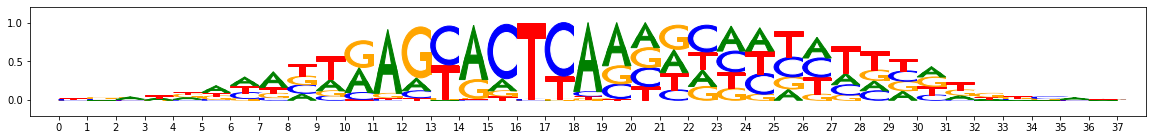

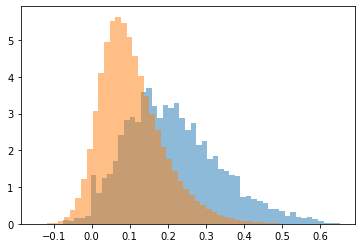

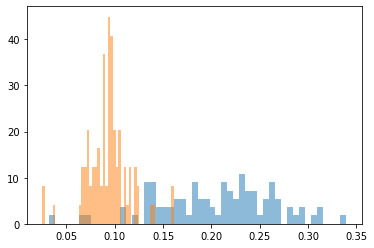

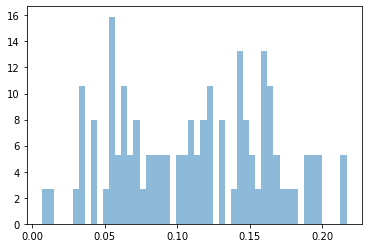

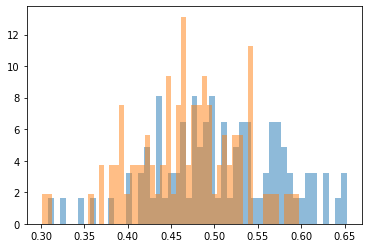

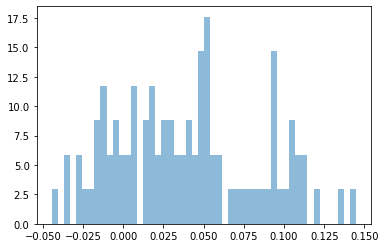

Cluster idx 13 size 89


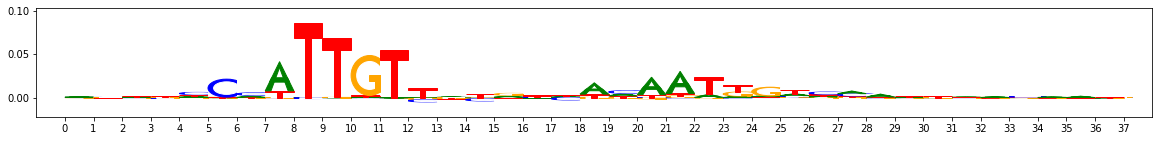

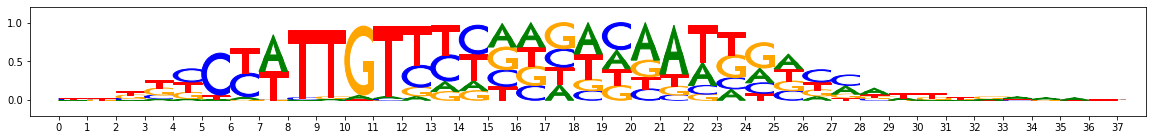

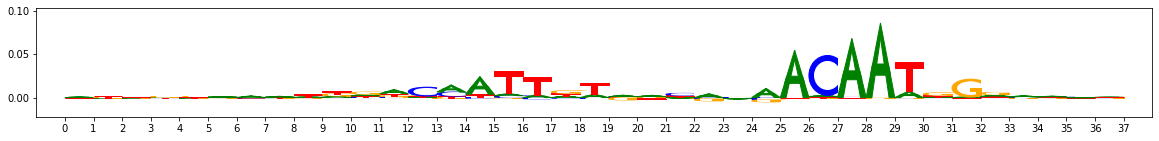

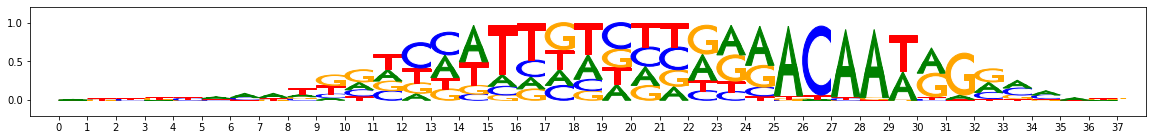

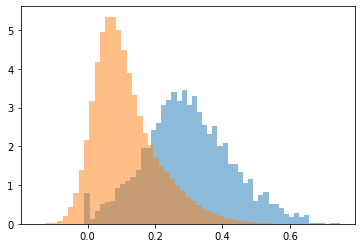

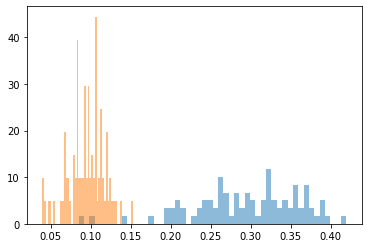

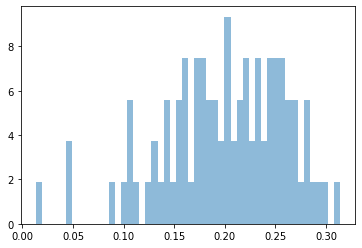

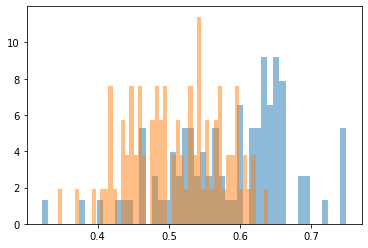

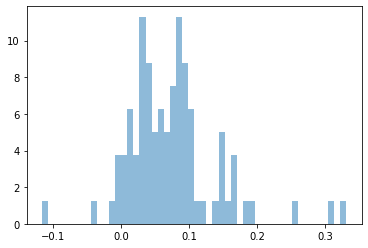

Cluster idx 14 size 85


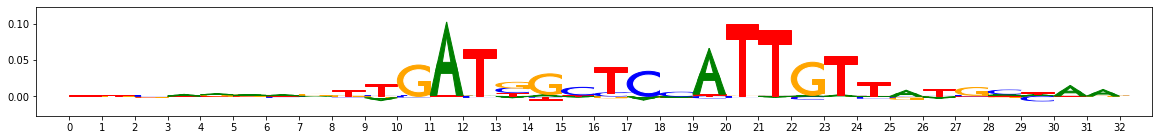

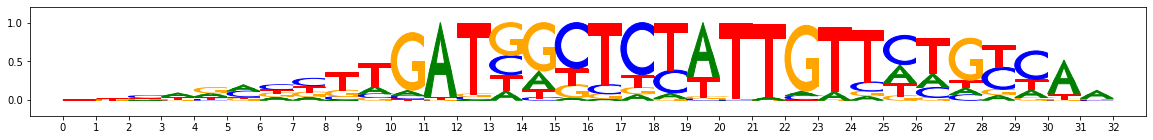

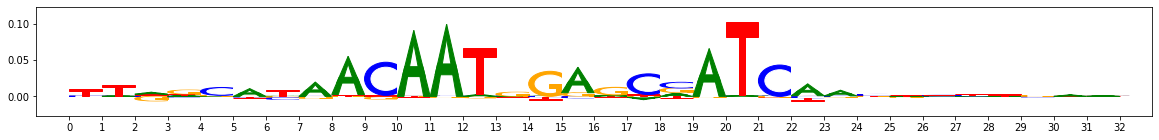

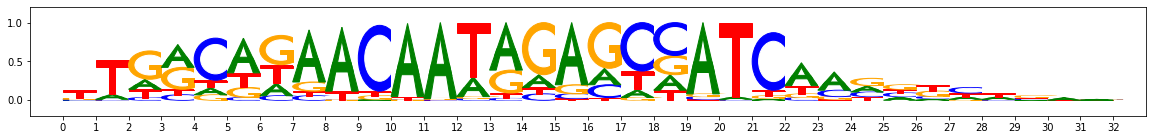

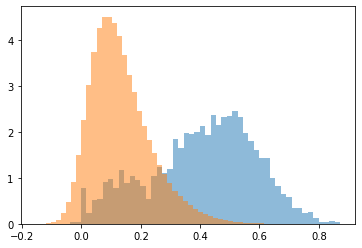

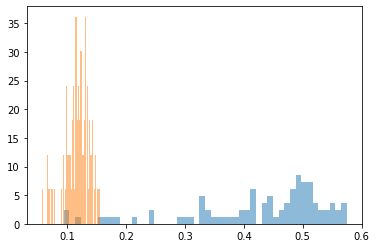

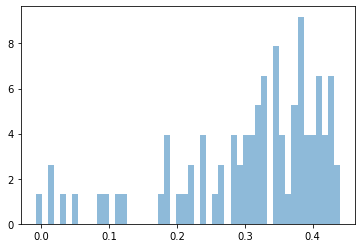

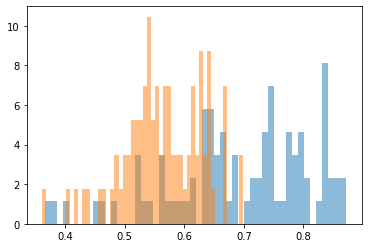

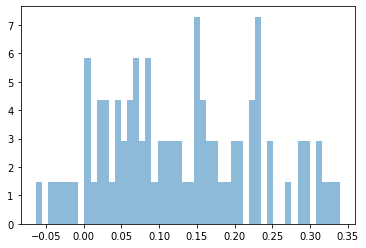

Cluster idx 15 size 85


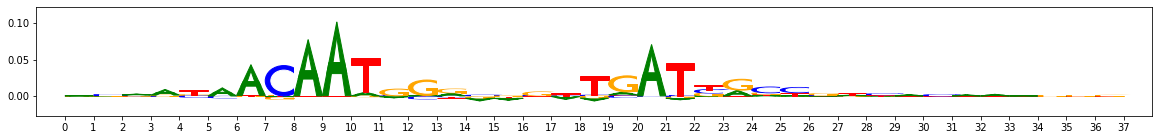

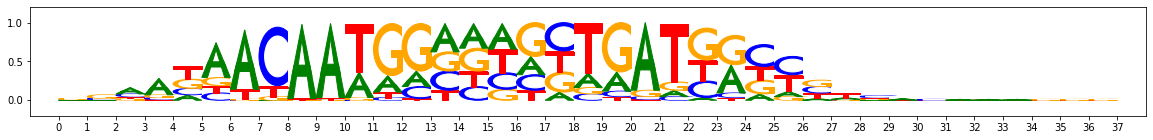

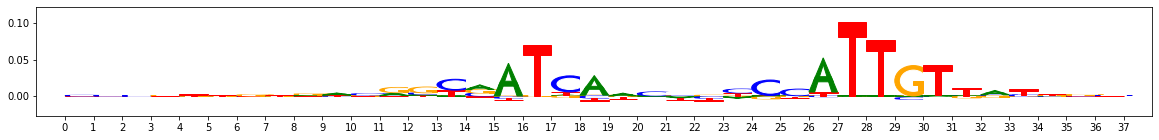

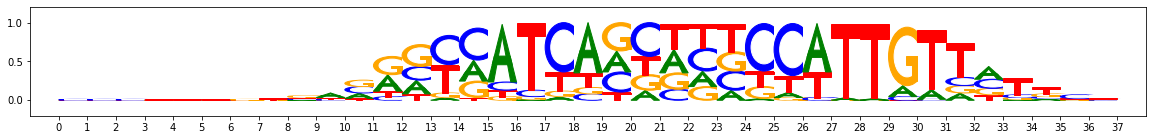

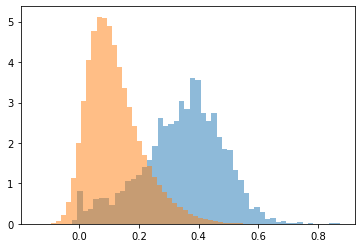

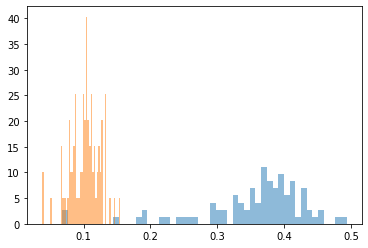

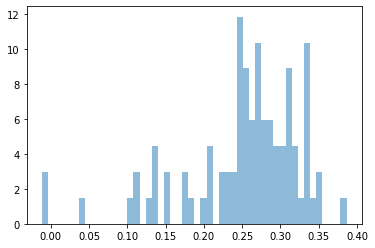

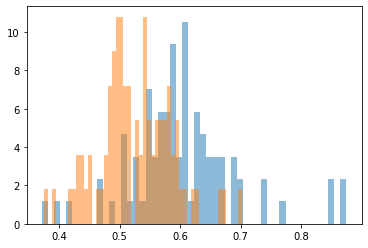

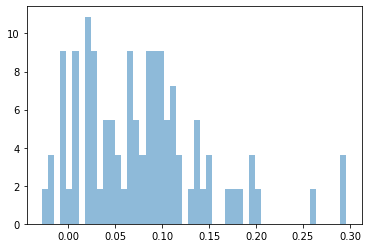

Cluster idx 16 size 84


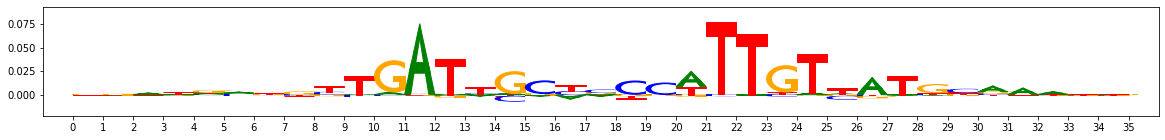

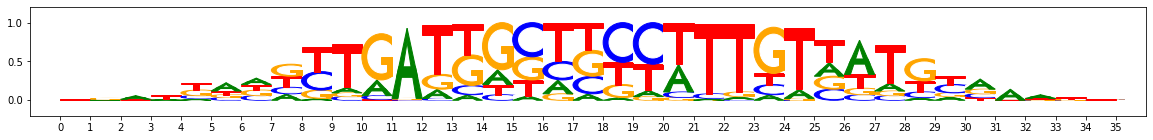

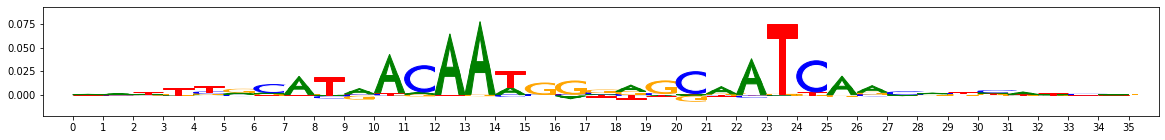

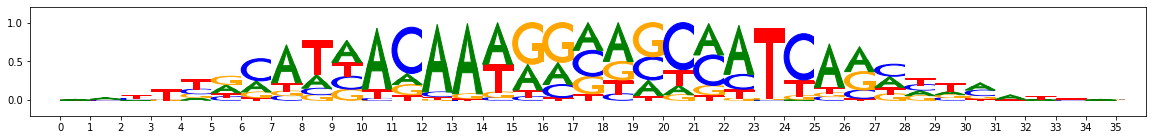

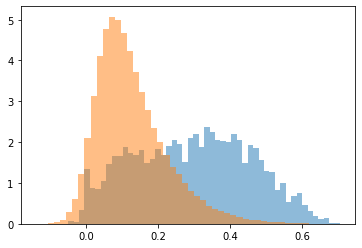

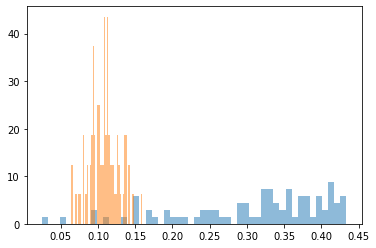

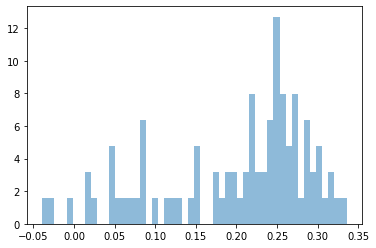

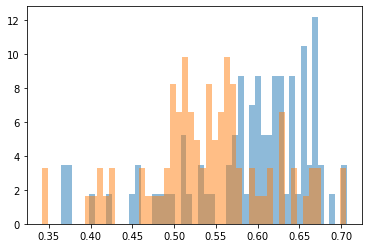

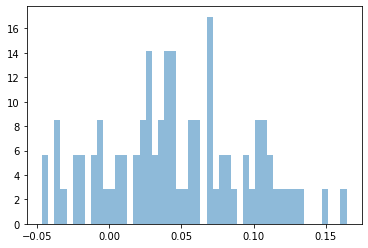

Cluster idx 17 size 80


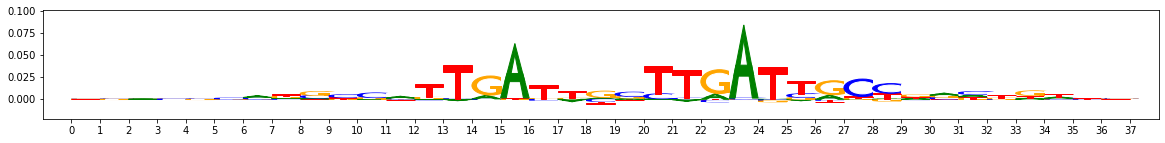

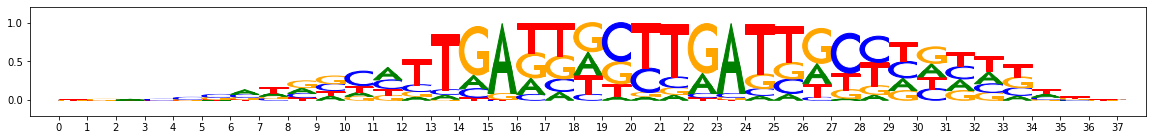

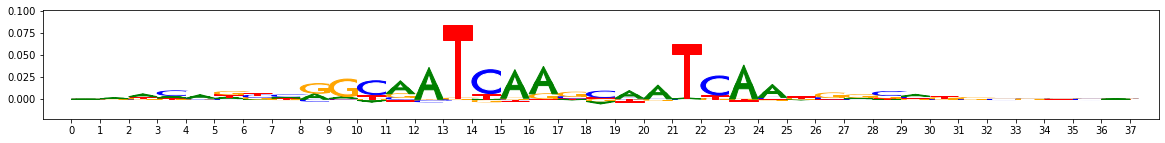

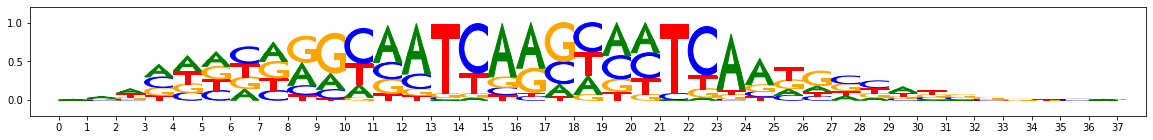

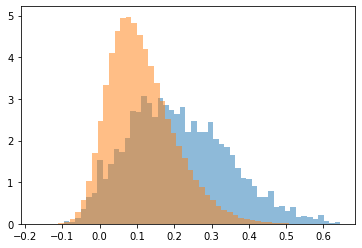

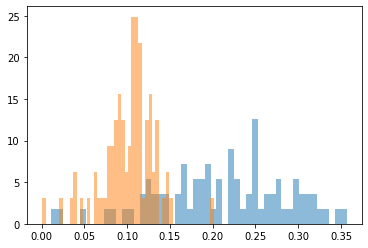

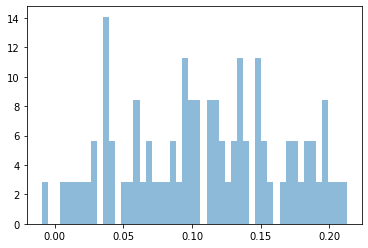

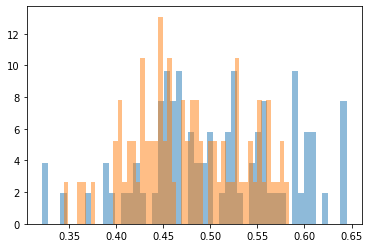

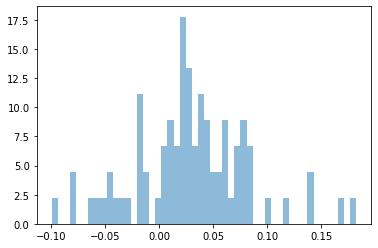

Cluster idx 18 size 77


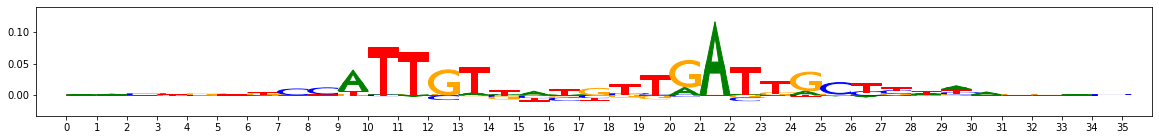

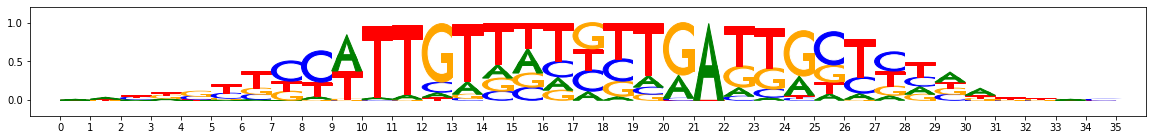

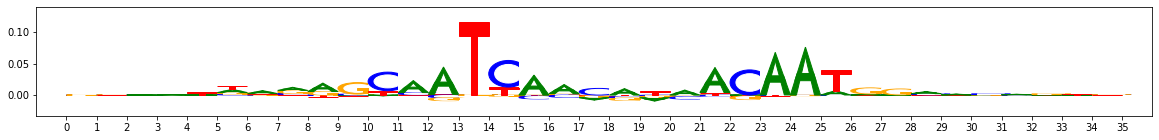

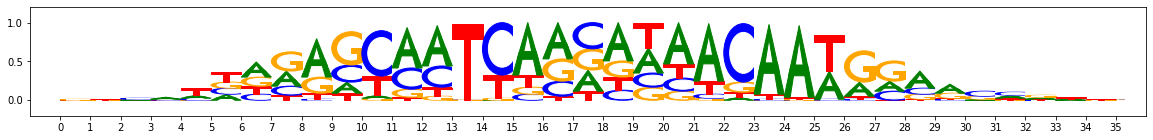

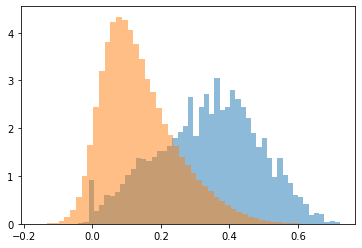

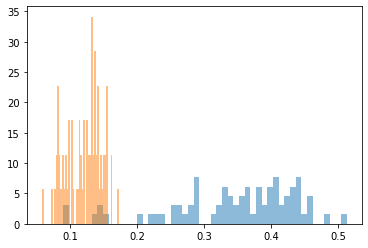

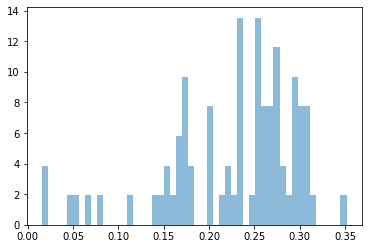

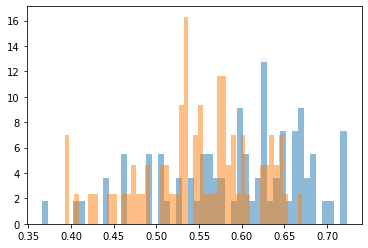

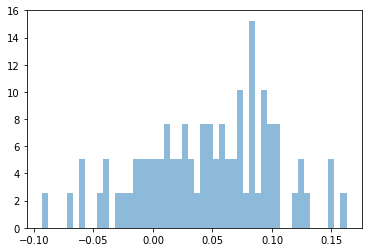

Cluster idx 19 size 76


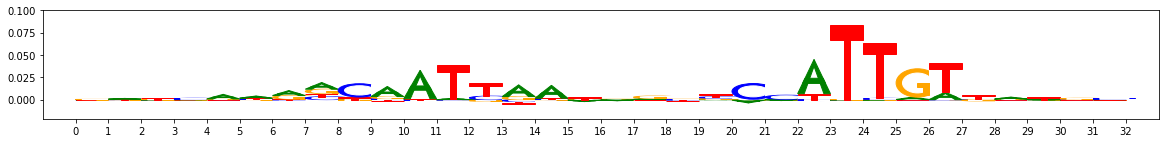

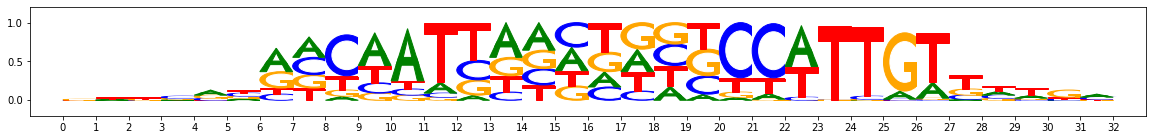

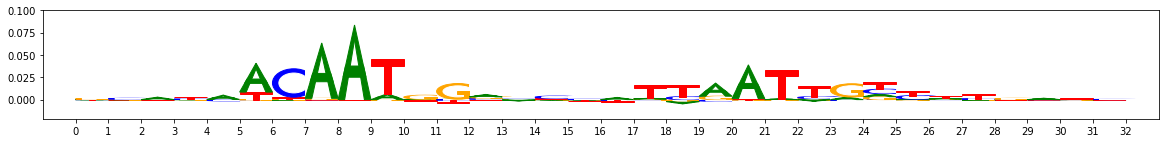

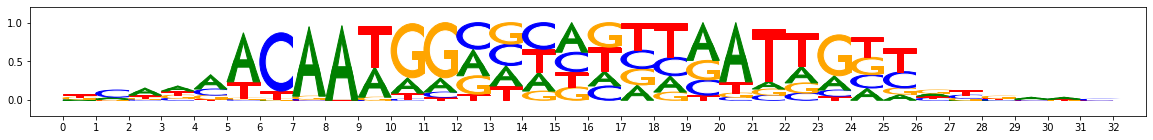

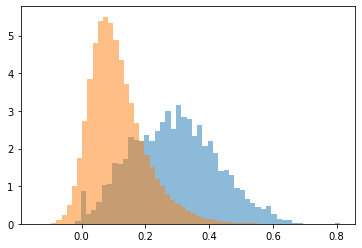

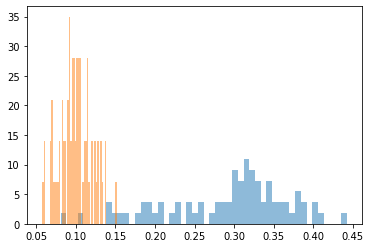

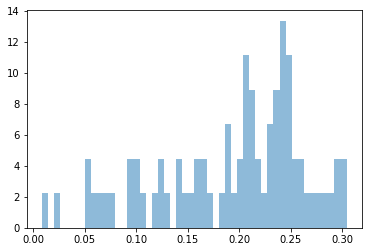

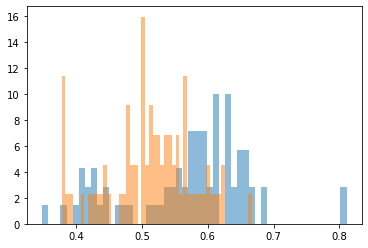

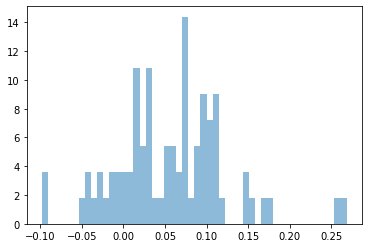

Cluster idx 20 size 72


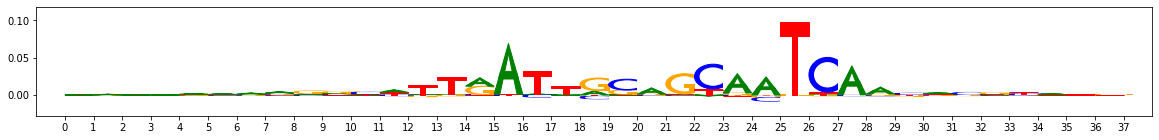

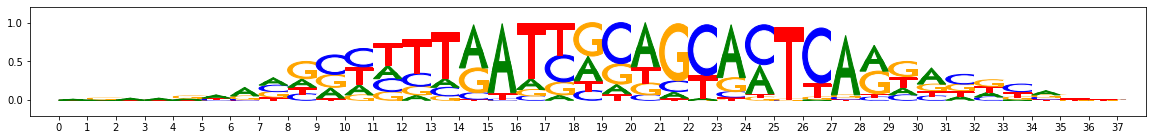

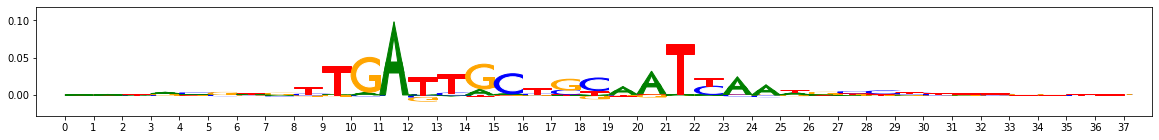

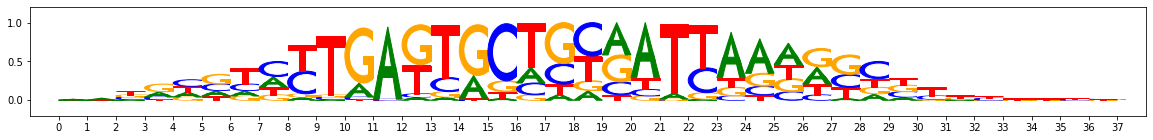

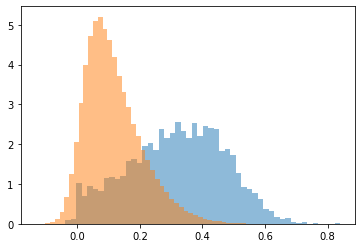

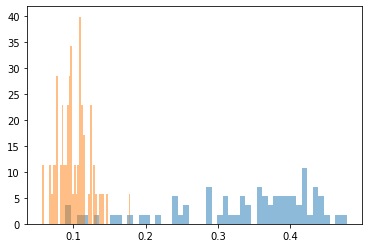

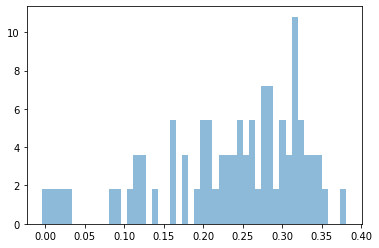

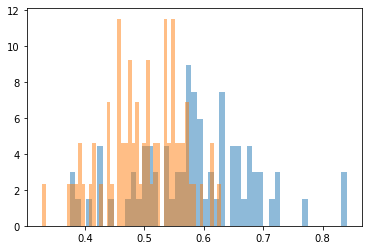

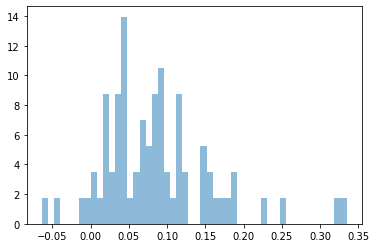

Cluster idx 21 size 69


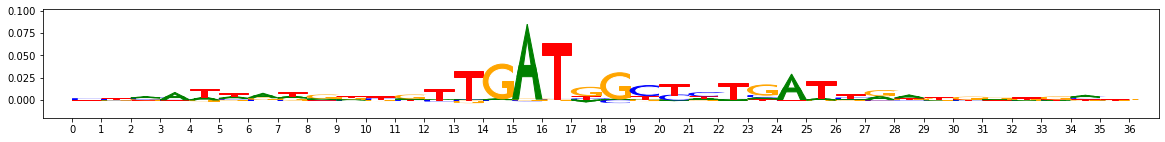

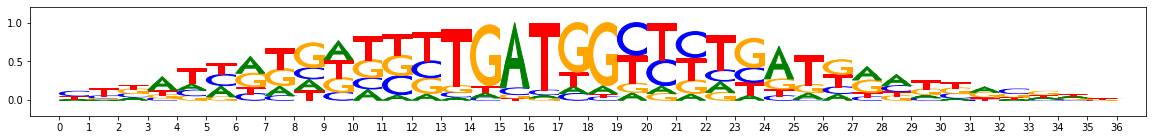

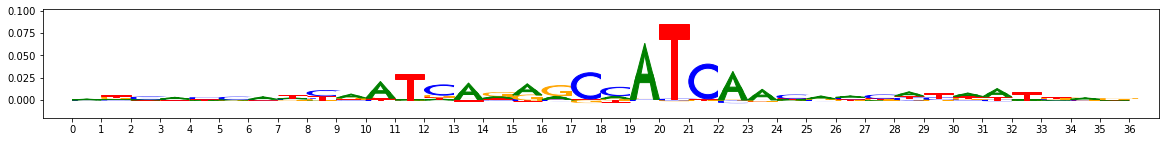

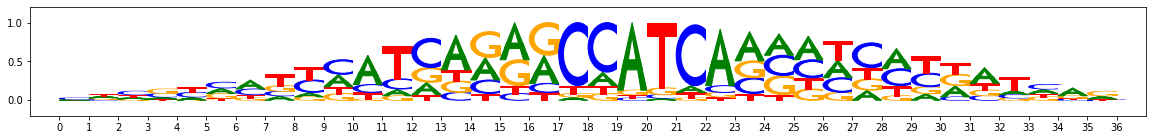

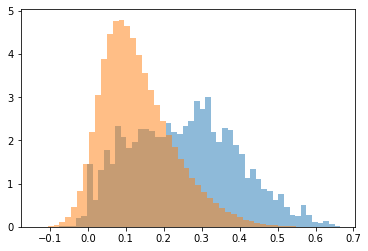

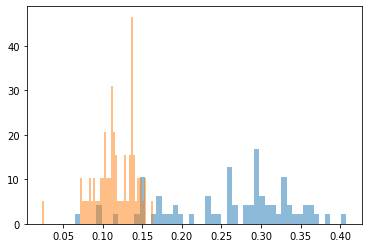

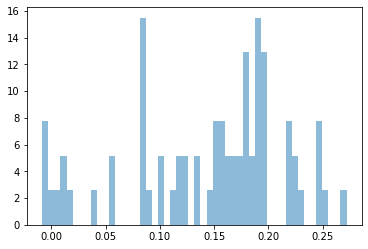

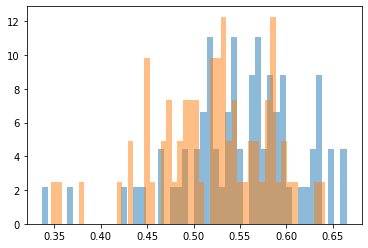

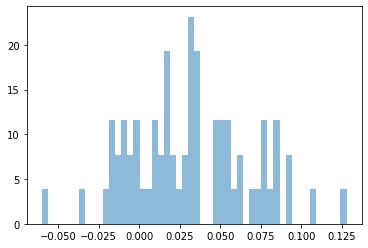

Cluster idx 22 size 66


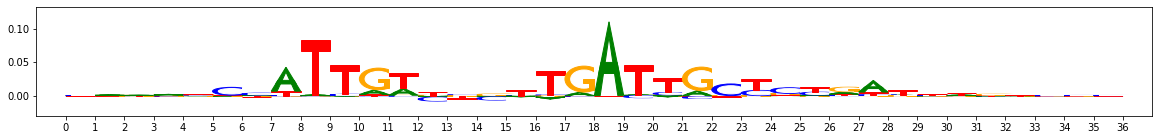

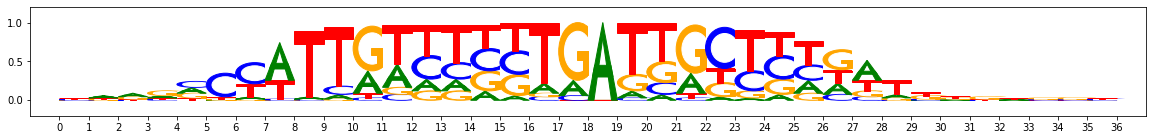

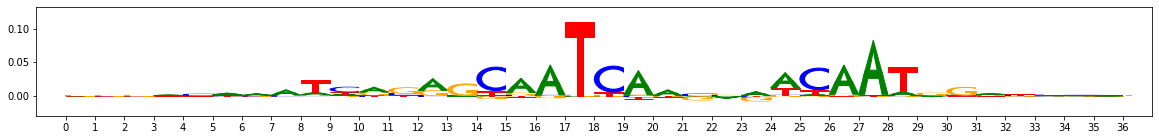

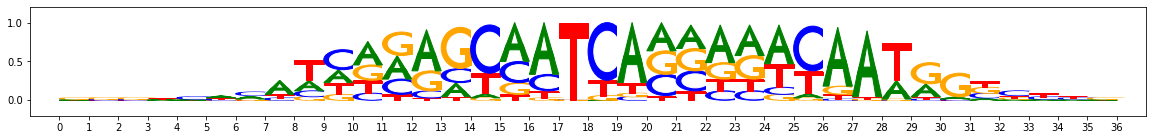

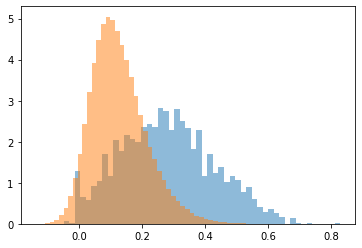

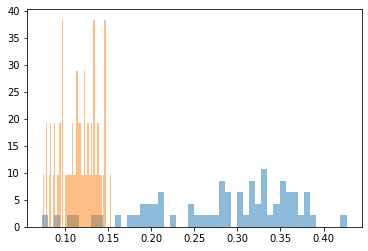

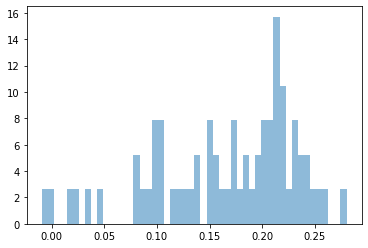

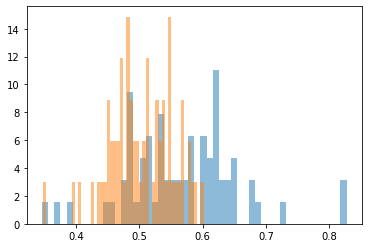

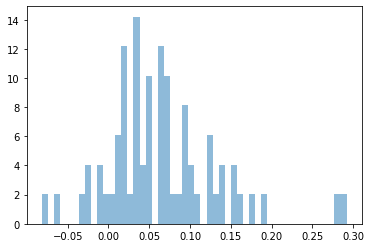

Cluster idx 23 size 62


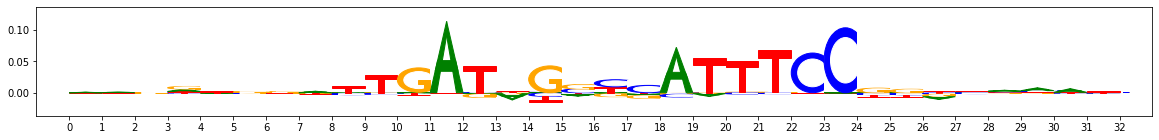

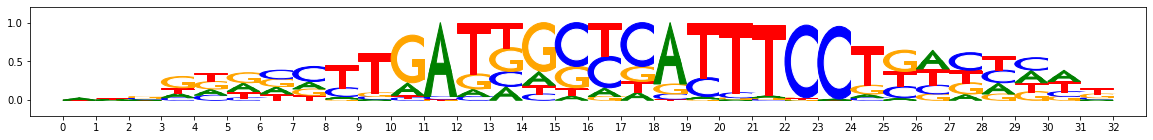

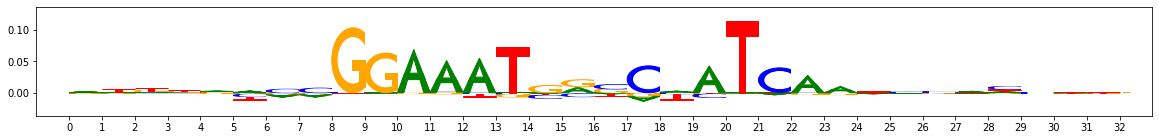

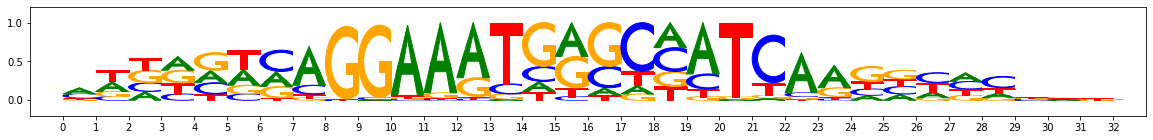

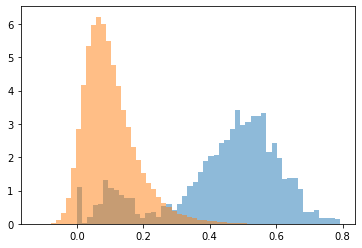

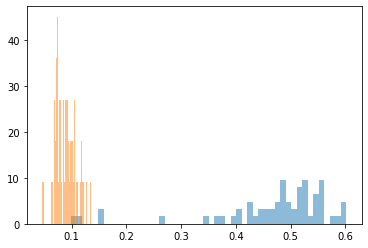

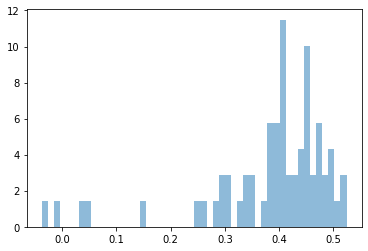

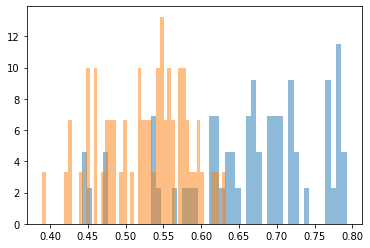

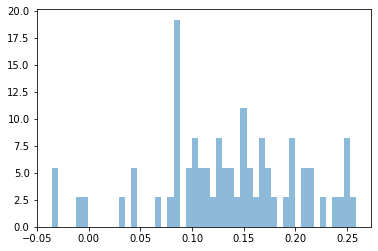

Cluster idx 24 size 62


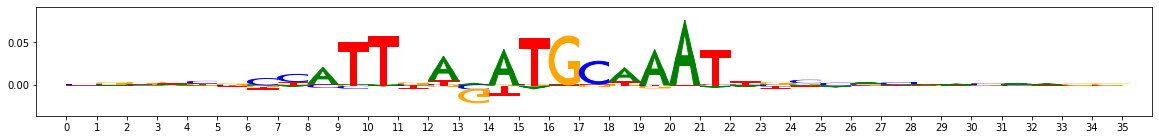

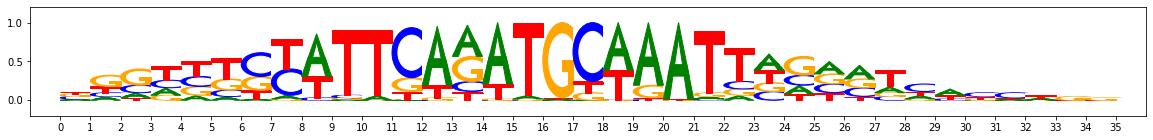

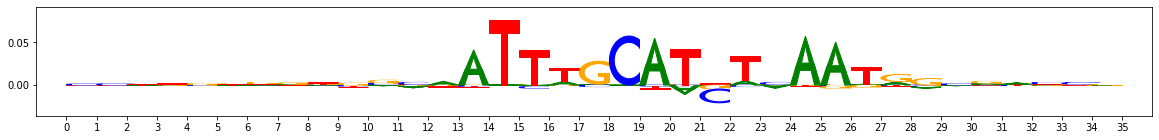

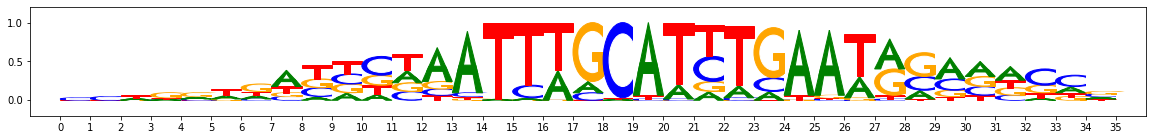

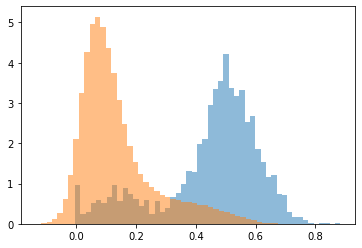

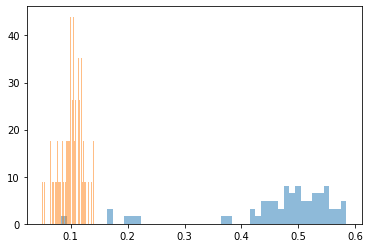

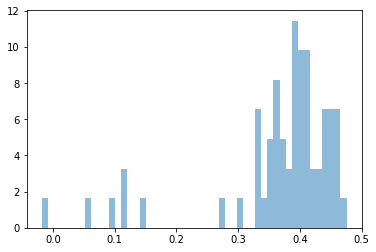

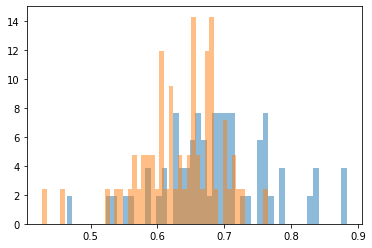

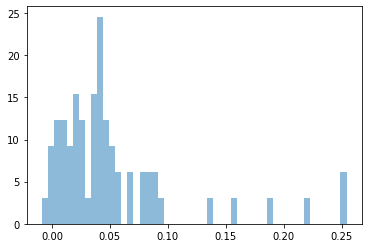

Cluster idx 25 size 59


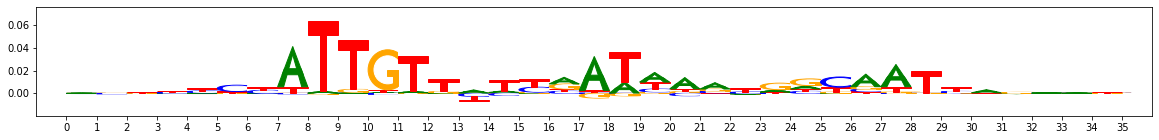

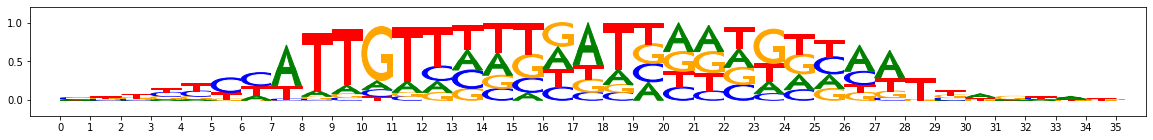

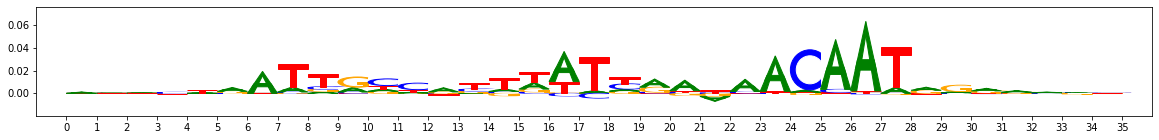

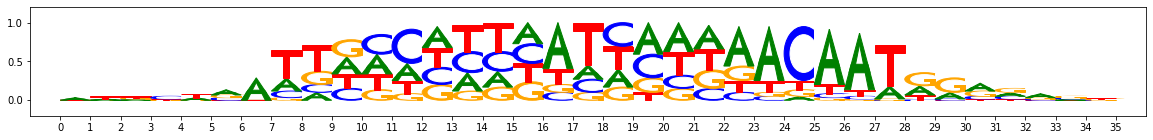

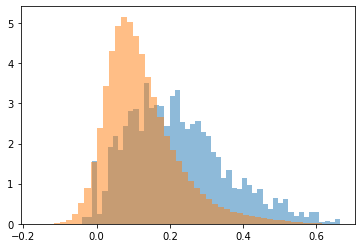

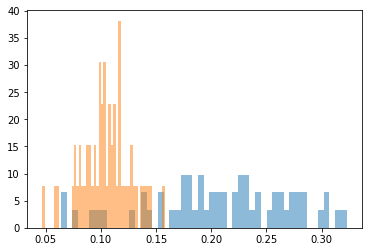

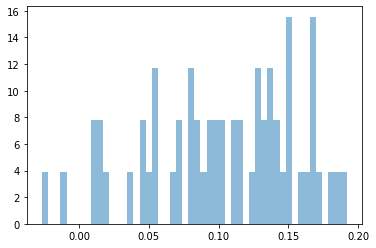

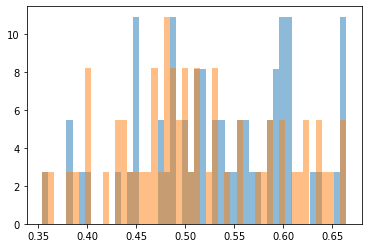

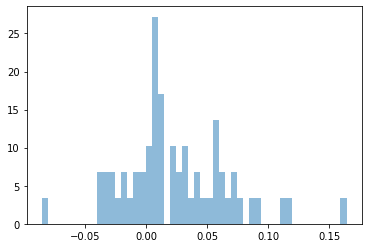

Cluster idx 26 size 58


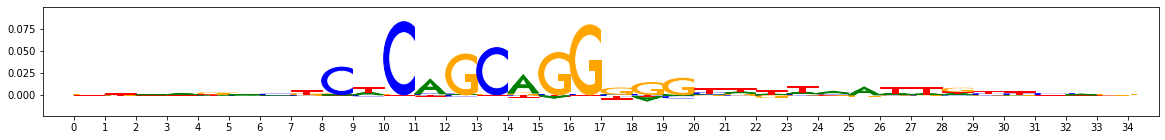

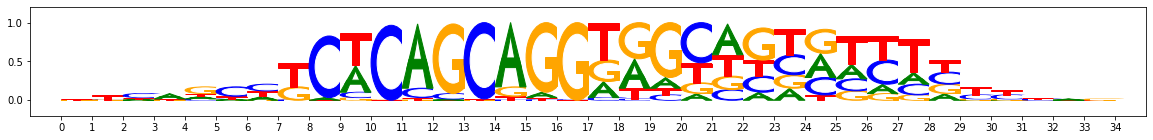

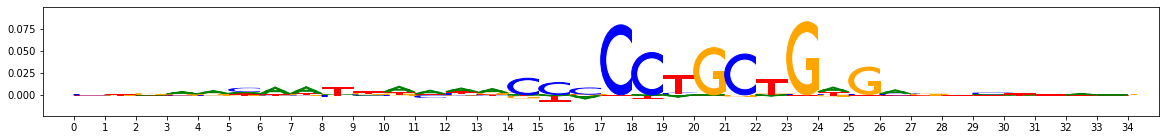

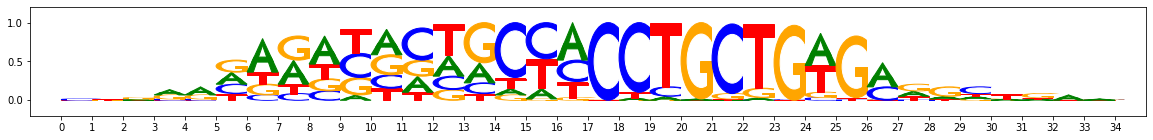

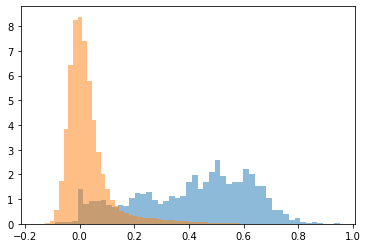

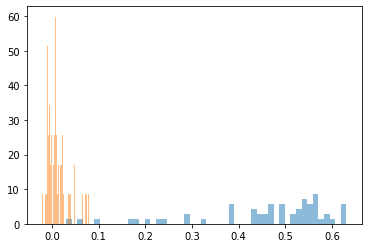

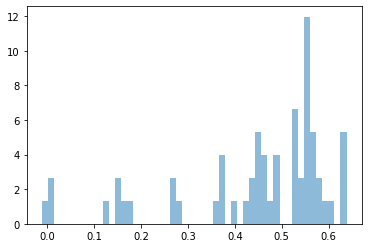

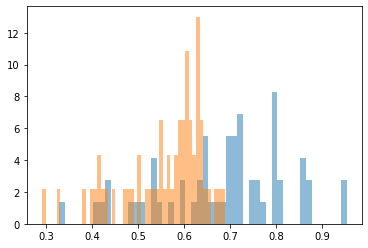

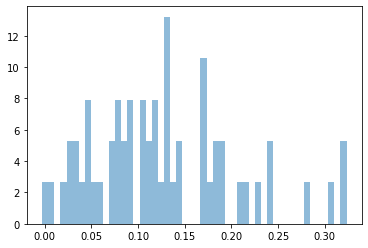

Cluster idx 27 size 58


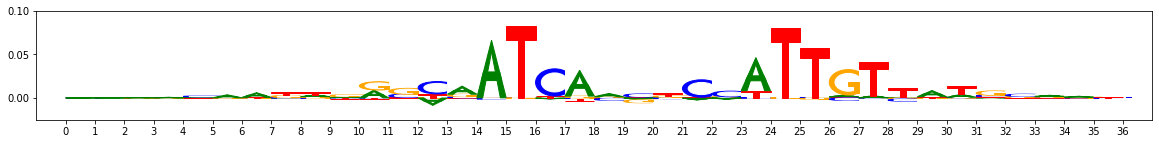

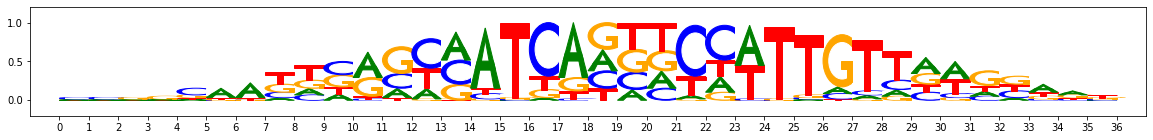

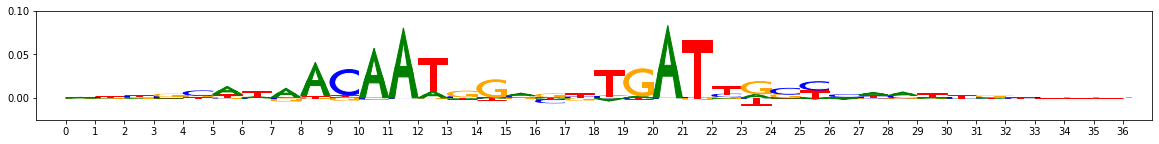

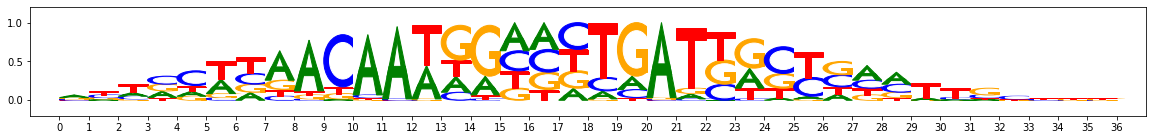

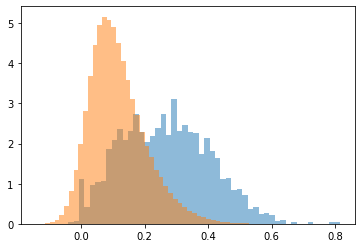

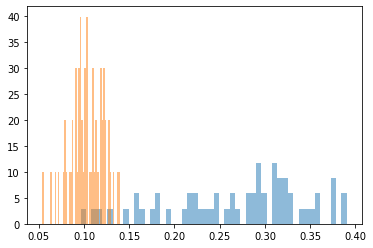

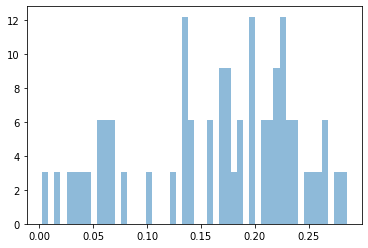

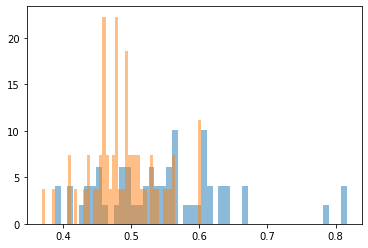

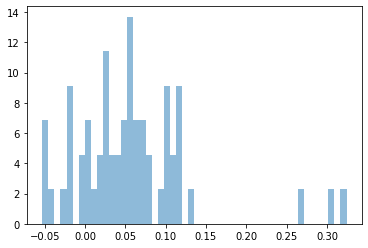

Cluster idx 28 size 58


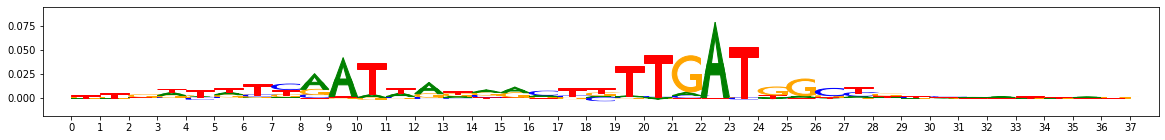

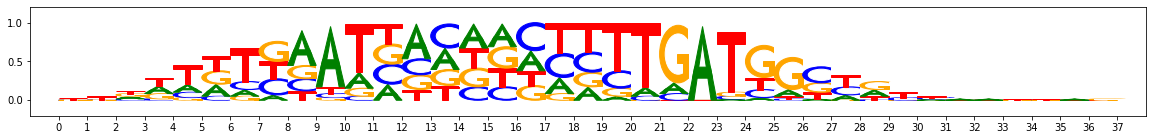

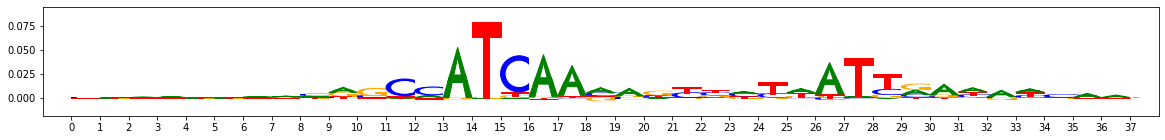

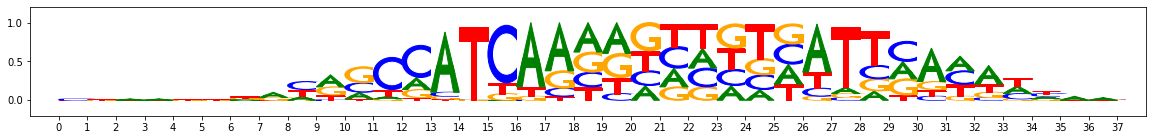

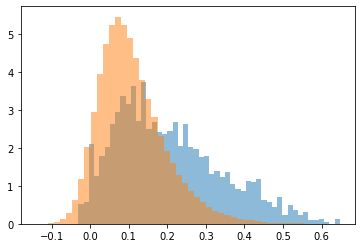

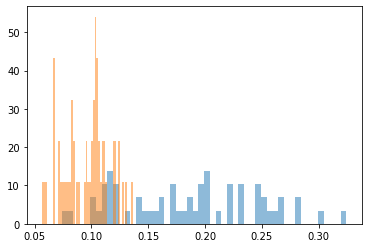

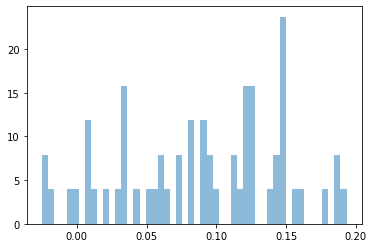

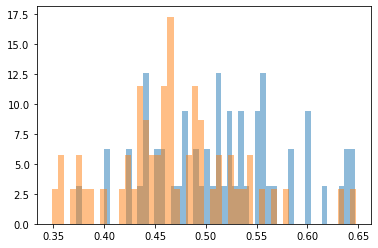

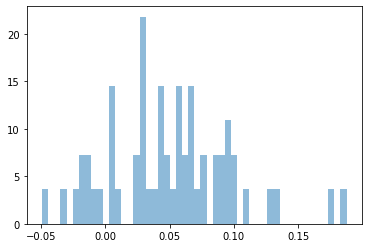

Cluster idx 29 size 58


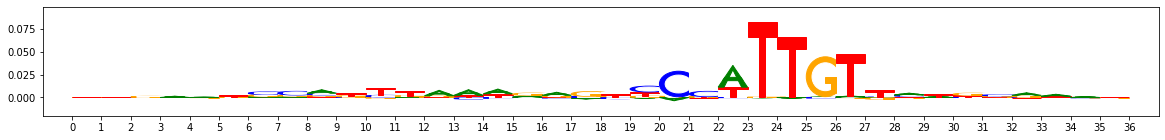

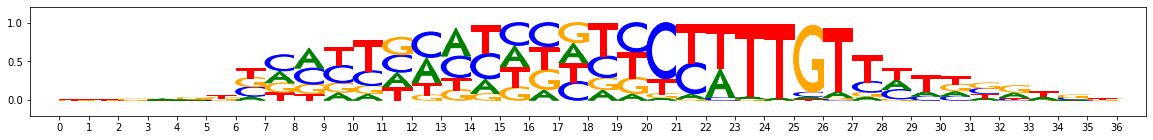

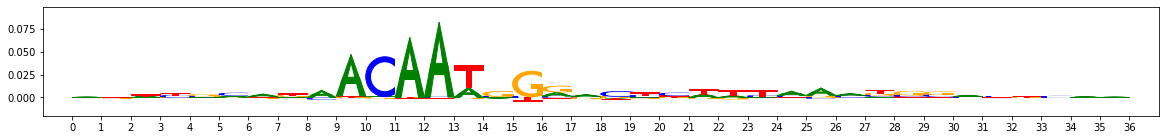

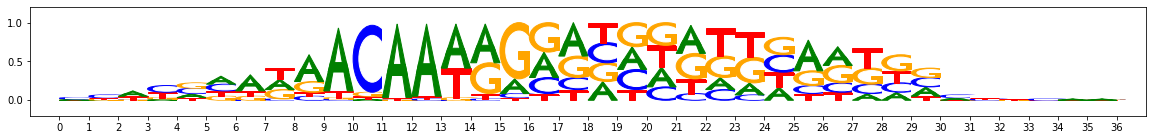

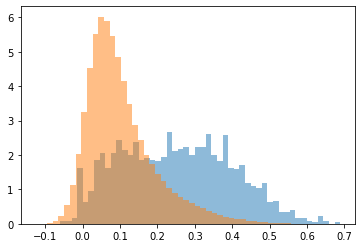

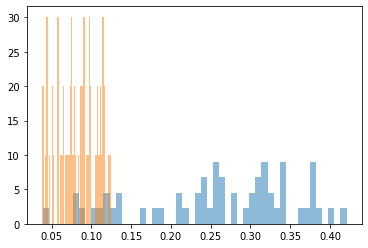

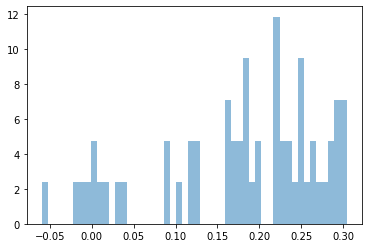

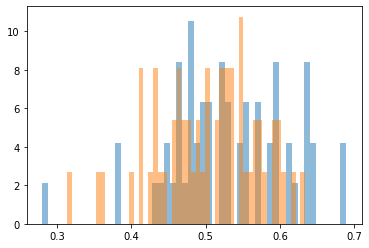

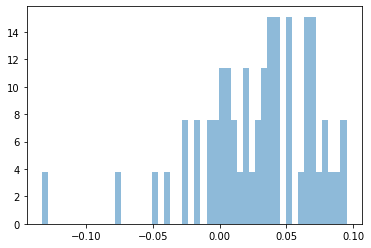

Cluster idx 30 size 57


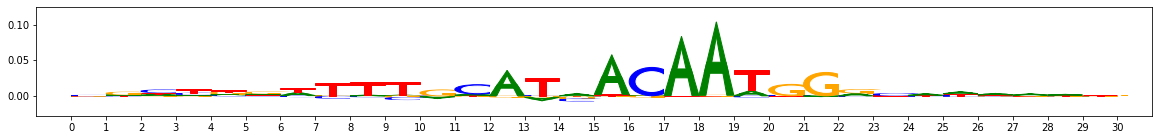

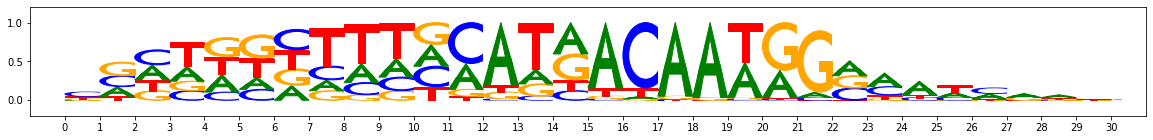

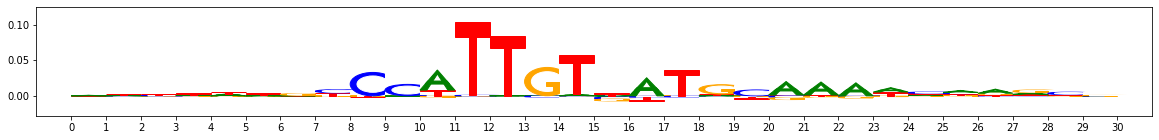

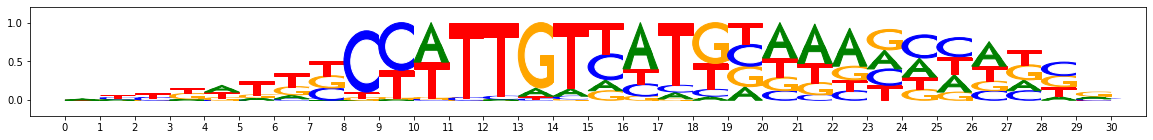

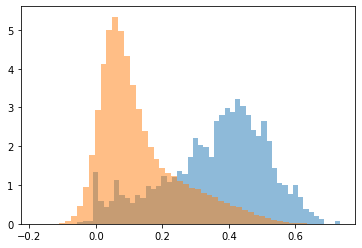

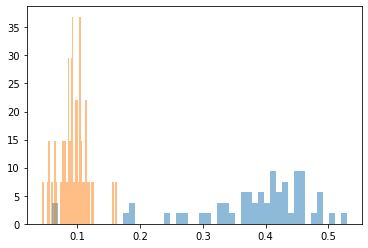

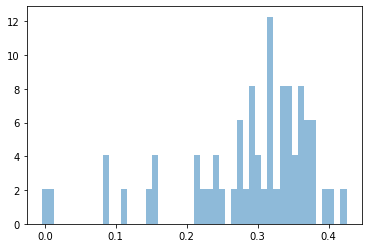

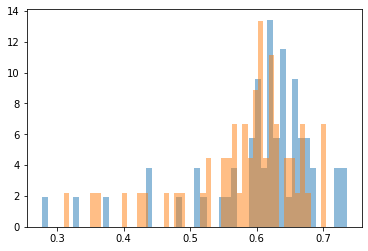

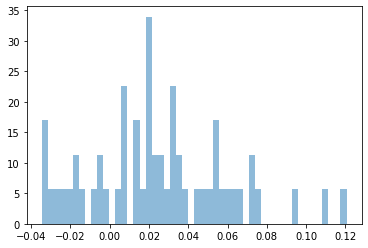

Cluster idx 31 size 55


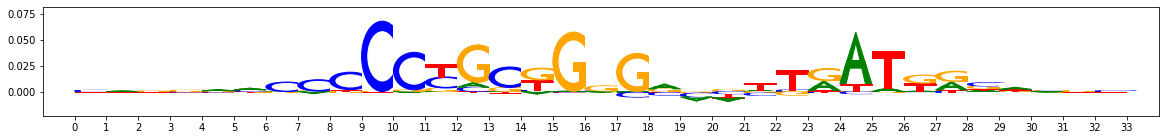

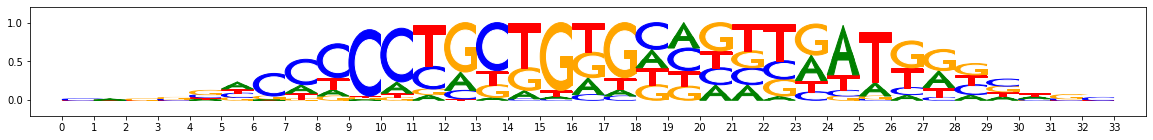

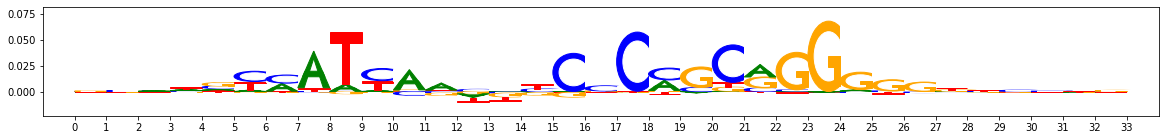

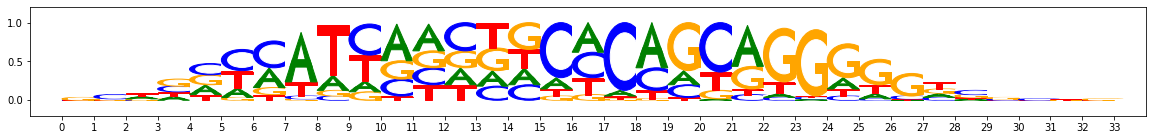

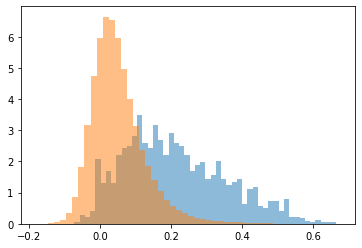

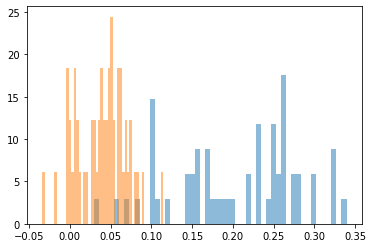

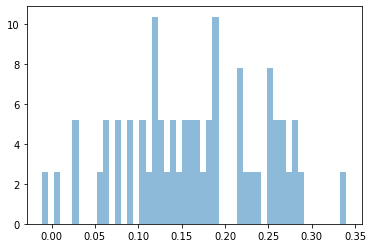

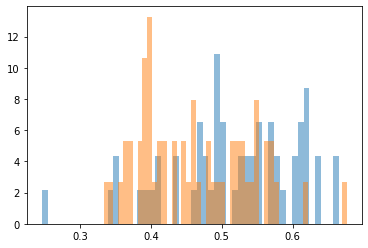

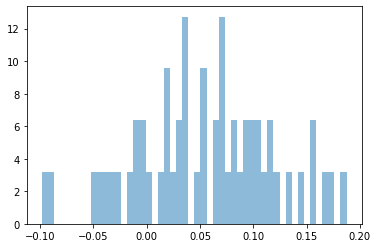

Cluster idx 32 size 51


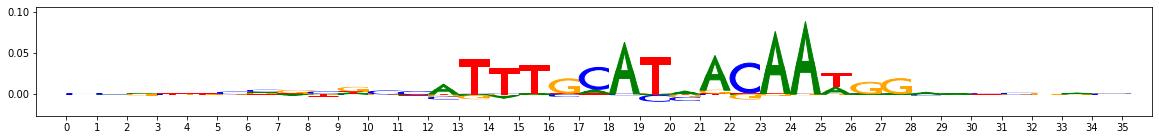

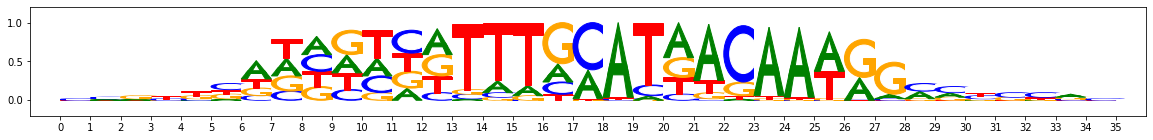

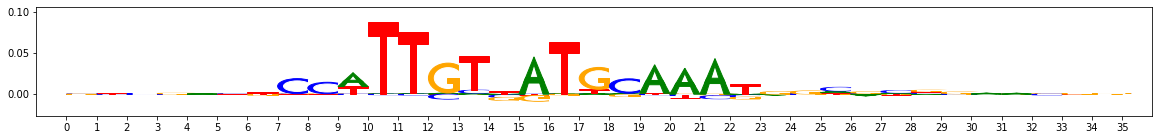

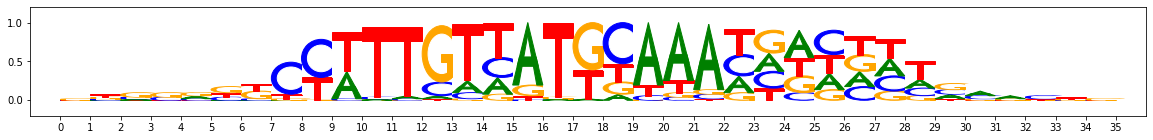

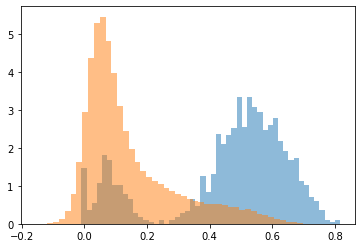

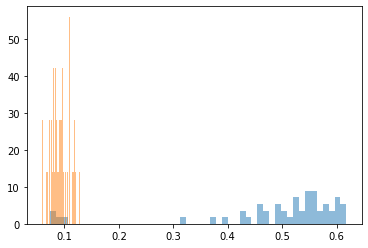

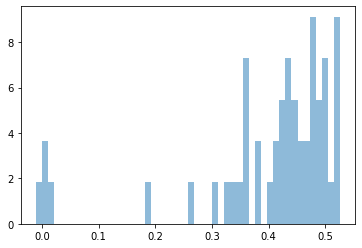

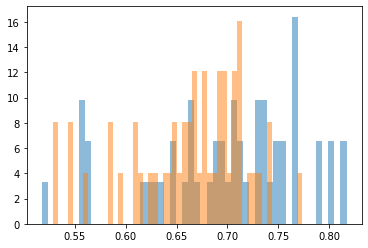

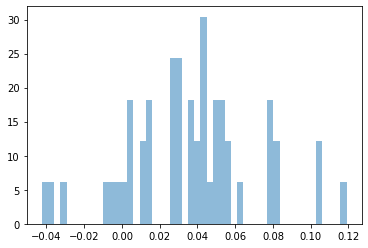

Cluster idx 33 size 50


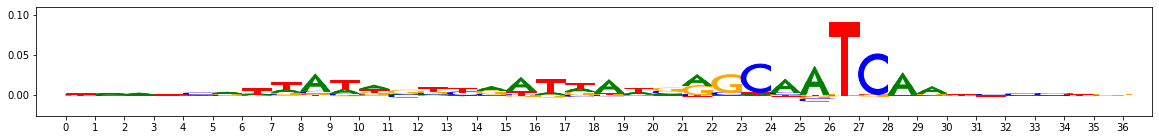

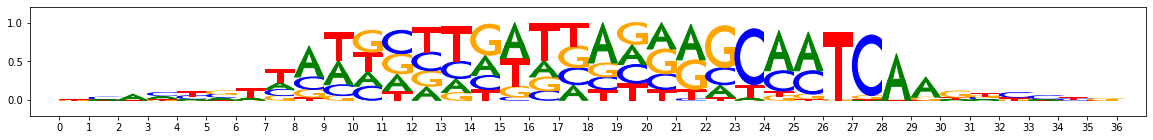

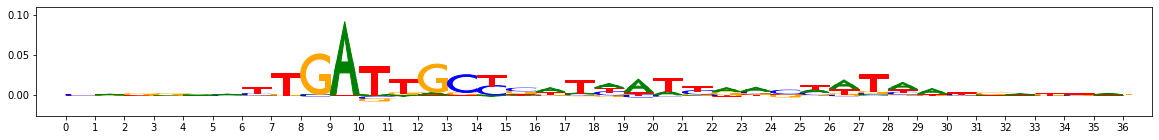

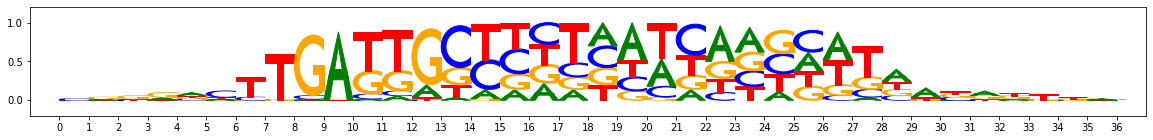

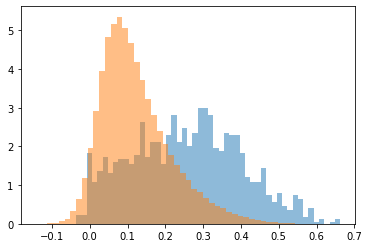

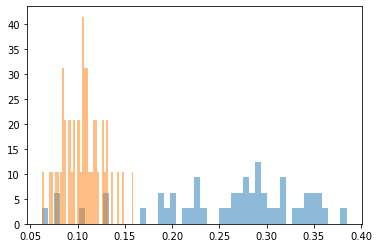

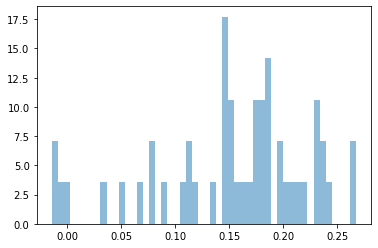

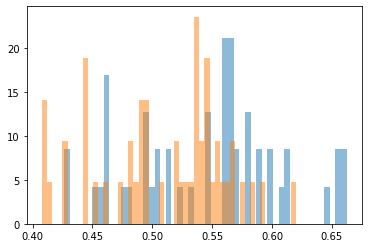

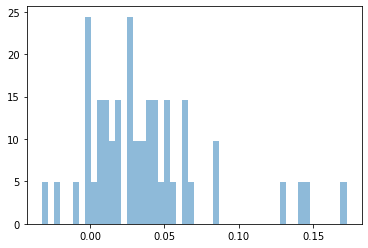

Cluster idx 34 size 50


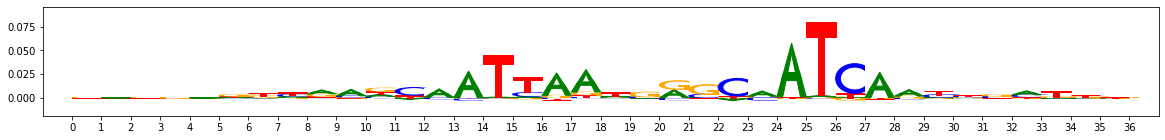

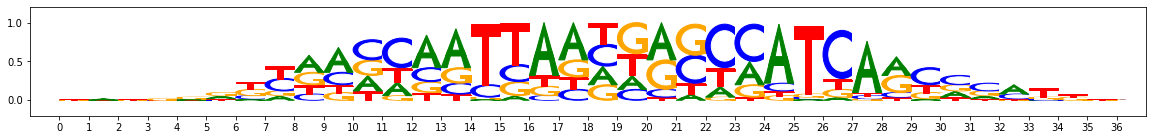

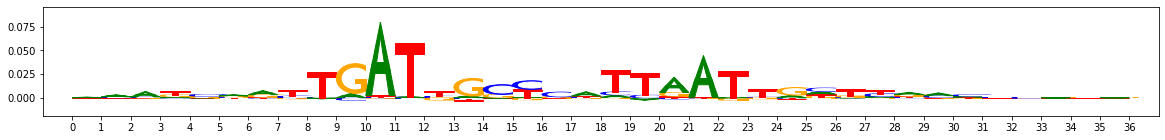

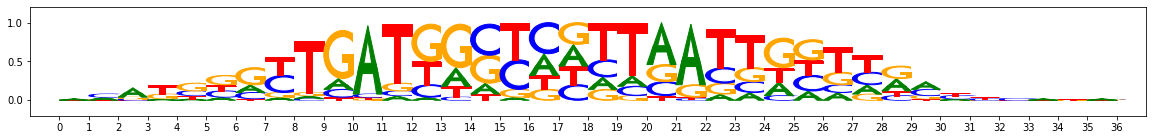

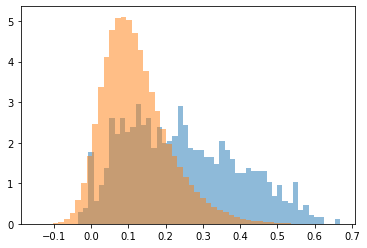

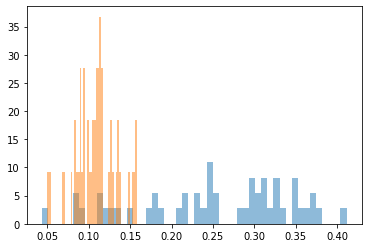

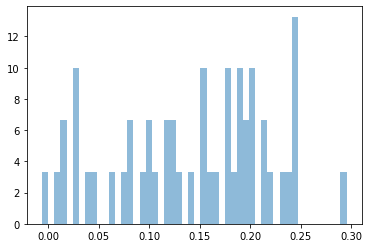

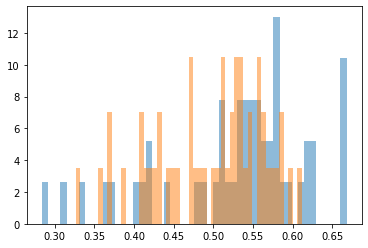

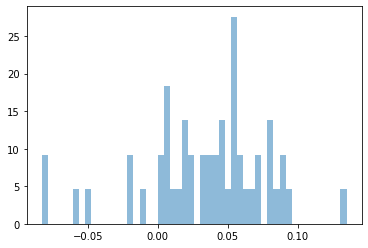

Cluster idx 35 size 49


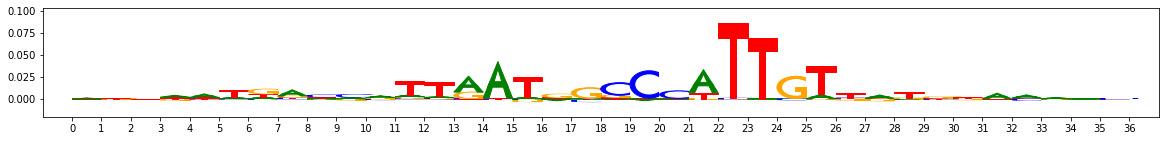

KeyboardInterrupt: 

In [25]:
reload(modisco.core)

seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets_subsample])

print("Numbed of clusters:",np.max(the_clustering)+1)
for idx in range(max(the_clustering)+1):
    in_cluster_mask = idx==the_clustering
    
    print("Cluster idx",idx,"size",np.sum(in_cluster_mask))
    if (np.sum(in_cluster_mask) > 20):
        #find an exemplar for the cluster as the one with the minimum total distance to all the others
        #ok this doesn't work that well
        #exemplar = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)+((in_cluster_mask==False)*np.inf))
        exemplar = np.argmax(seqletimps*in_cluster_mask) #highest imp for exemplar - this works better

        distsortinfo = np.argsort(distmat[in_cluster_mask, exemplar])
        isfwdinfo = isfwdmat[in_cluster_mask,exemplar][distsortinfo]
        offsetsinfo = offsets[in_cluster_mask,exemplar][distsortinfo]
        seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets_subsample, in_cluster_mask) if incluster]
        seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in distsortinfo]
        oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                       for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
        #for aseqlet in oriented_seqlets_in_cluster[:3]:
        #    viz_sequence.plot_weights(aseqlet["contrib_scores"].corefwd)
        aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:100],
                                                          offsets=offsetsinfo[:100])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].rev)
        #plot the distribution of pairwise dissimilarities within the cluster
        zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False].ravel(), bins=50, density=True, alpha=0.5)
        plt.show()
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
                 - np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
                 - np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()